In [42]:
import numpy as np
import cvxpy as cp
import scipy
import mosek
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [43]:
n = 10 #number of stocks
T_train = 100 # training period
T_test = 100 #testing period
T_truetest = 1000 # out of sample testing period

In [44]:
#parameters for generating normal returns
mu = 0.0 + np.linspace(-0.1, 0.5, n)
cov = np.ones((n,n))+np.eye(n)
cov = 1 * cov
print(mu)
print(cov)

[-0.1        -0.03333333  0.03333333  0.1         0.16666667  0.23333333
  0.3         0.36666667  0.43333333  0.5       ]
[[2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 2. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 2. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]]


In [45]:
#generating in-sample returns from Gaussian
def generate_data():
    mean = mu
    covariance = cov
    data = np.random.multivariate_normal(mean, covariance, T_train + T_test + T_truetest)
    #data = np.vstack((data, np.random.multivariate_normal(mean , covariance, T_test)))
    return data

In [47]:
#generating mask --- MCAR
def missing(miss_prob=0.5):
    #''True'' represents missing
    mask = np.random.choice([True, False], size = (T_train,n), p = [miss_prob, 1-miss_prob])
    mask = np.vstack((mask, np.full((T_test + T_truetest,n),False))) #no missing value for testing period
    return mask

In [49]:
#prior for the paramter \mu, use flat prior
mu_p = np.repeat(0.0,n)
covp_inv = np.diag(np.full(n,0.0))
print(mu_p)
print(covp_inv)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [50]:
def individualposterior(data, mask, mu0, cov0_inv):
    
    meanlist = []
    covariancelist = []
    num_posteriors = T_test + 1
    
    covariance_mu_inv = np.copy(cov0_inv)
    mean_mu = np.matmul(covariance_mu_inv,mu0)
     
    for t in range(T_train + T_test):
        
        if not np.all(mask[t,:] == np.full(n,True)):
            
            ind = (mask[t,:] == np.full(n,False))
            cov_t = cov[np.ix_(ind,ind)]
            cov_inv_expand = np.zeros((n,n))
            cov_inv_expand[np.ix_(ind,ind)] = np.linalg.inv(cov_t)

            covariance_mu_inv += cov_inv_expand

            mean_t = np.zeros(n)
            mean_t[ind] = data[t,ind]
            mean_mu += np.matmul(cov_inv_expand,mean_t)
        
        if t >= (T_train - 1):
        
            covariance_mu = np.linalg.inv(covariance_mu_inv)
            covariancelist.append(covariance_mu)
            meanlist.append(np.matmul(covariance_mu, mean_mu))
    return meanlist,covariancelist  

In [60]:
def consensuswasserstein(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    weights = cp.Variable(2)
        
    Sigma1 = covariancelist[0]
    Sigma2 = covariancelist[-1]
    temp = sqrtm(Sigma2) @ Sigma1 @ sqrtm(Sigma2)
    Psi = sqrtm(Sigma2) @ np.real(scipy.linalg.inv(sqrtm(temp))) @ sqrtm(Sigma2)
    
    P = np.zeros((2,2))
    P[0,0] = np.trace(Sigma1)
    P[1,1] = np.trace(Sigma2)
    P[0,1] = np.trace(Sigma1 @ Psi)
    P[1,0] = np.trace(Sigma1 @ Psi)
   
    obj = cp.quad_form(weights, P)
    
    constraints = [weights >= 0,
                   cp.sum(weights) == 1,
                   weights[1] <= delta_r]
    
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    
    solution = weights.value
   
    final_mu = meanlist[0] * solution[0] + meanlist[-1] * solution[1]
    final_sigma = (solution[0]*np.eye(n) + solution[1] * Psi) @ Sigma1 @ (solution[0]*np.eye(n) + solution[1] * Psi)
    
    return solution, final_mu, final_sigma

In [61]:
def consensuswasserstein_general(meanlist,covariancelist,delta_r, prediction):#prediction是mu_1
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    
    s_list = []
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
    
    sv_matrix = np.array(s_list)
    
    #P = np.zeros((num_posteriors,num_posteriors))
    #for i in range(num_posteriors): 
        #for j in range(num_posteriors):
            #P[i,j] = np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
            #np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:]))是(d_{i1}d_{j1})^{1/2}+...+(d_{in}d_{jn})^{1/2},其实可以换成np.inner的
            
    #obj = 0
    #for i in range(num_posteriors): 
    #    for j in range(num_posteriors):
    #        obj += weights[i] * weights[j] * np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
    
    
    #obj = cp.sum_squares(weights @ sv_matrix)
    obj = cp.sum_squares(sv_matrix.T @ weights.T)
    #obj = cp.quad_form(weights, P)
    delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    temp = 0
    for i in range(num_posteriors):
        temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
    constraints.append(cp.norm(temp-prediction)<=delta)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    
    solution = weights.value
    
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += solution[i]*meanlist[i]
    final_sigma = np.zeros((n,n))
    for i in range(num_posteriors):
        for j in range(n):
            final_sigma += solution[i] * np.sqrt(sv_matrix[i,j]) * np.outer(v[:,j],v[:,j])
    final_sigma = final_sigma @ final_sigma
    
    return solution, final_mu, final_sigma

In [117]:
def consensusbackwardkl(meanlist,covariancelist,delta_r,prediction,weight_init,epsilon,max_iter):#weight_init = np.full(num_posteriors,1/num_posteriors)
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    mu_list = []
    
    obj1 = 0
    for i in range(num_posteriors):
        mean_k = meanlist[i]
        mu_list.append(mean_k)
        obj1 += weights[i]*cp.trace(np.outer(mean_k,mean_k)+covariancelist[i])
        
    mu_matrix = np.array(mu_list)
    
    weight_t = weight_init
    weight_former = np.zeros(num_posteriors)
    iteration = 0
    
    while np.linalg.norm(weight_t-weight_former) > epsilon and iteration < max_iter:
        
        weight_former = weight_t
        
        #obj2 = 2*np.inner(np.matmul(mu_matrix,weight_t),np.matmul(mu_matrix,weights))
        obj2 = 2*(np.inner(weight_t,np.inner(mu_matrix,mu_matrix))@ weights)
        
        for i in range(num_posteriors):
            for j in range(num_posteriors):
                obj3 = -weight_t[i]*weight_t[j]*np.inner(meanlist[i],meanlist[j])
        
        obj = obj1+obj2+obj3
    
        delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
        constraints = [weights >= 0,
                   cp.sum(weights) == 1]
        temp = 0
        for i in range(num_posteriors):
            temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
        constraints.append(cp.norm(temp-prediction,"inf")<=delta)
        #temp = 0
        #for j in range(n): #j:0,...n-1
        #    for i in range(num_posteriors):
        #        temp += weights[i]*meanlist[i][j]
        #    constraints.append(temp-prediction[j] <= delta)
        #    constraints.append(temp-prediction[j] >= -delta)
            
            
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.MOSEK)
    
        weight_t = weights.value
        iteration += 1
        print("weight diff:",np.linalg.norm(weight_t-weight_former))
        print("iteration:",iteration)
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += weight_t[i]*meanlist[i]
        
    final_sigma = np.zeros((n,n))
    final_sigma_1 = np.zeros((n,n))
    for i in range(num_posteriors):
        final_sigma_1 += weight_t[i]*(np.outer(meanlist[i],meanlist[i])+covariancelist[i])
    final_sigma = final_sigma_1 - np.outer(final_mu,final_mu)
    
    return weight_t, final_mu, final_sigma

In [38]:
#testing codes for consensusbackwardkl
data = generate_data()
mask = missing()
meanlist,covariancelist = individualposterior(data, mask, mu_p, covp_inv)
num_posteriors = len(meanlist)
n = len(meanlist[0])

weights = cp.Variable(num_posteriors)

mu_list = []
    
obj1 = 0   
for i in range(num_posteriors):
    mean_k = meanlist[i]
    mu_list.append(mean_k)
    obj1 += weights[i]*cp.trace(np.outer(mean_k,mean_k)+covariancelist[i])
    
mu_matrix = np.array(mu_list)
    
weight_t = np.full(num_posteriors,1/num_posteriors)

prediction = meanlist[0]

obj2 = 2*(np.inner(weight_t,np.inner(mu_matrix,mu_matrix))@weights)

        
for i in range(num_posteriors):
    for j in range(num_posteriors):
        obj3 = -weight_t[i]*weight_t[j]*np.inner(meanlist[i],meanlist[j])
        
obj = obj1+obj2+obj3
    
delta = 0
constraints = [weights >= 0,
                   cp.sum(weights) == 1]

temp = 0
for i in range(num_posteriors):
    temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
constraints.append(cp.norm(temp-prediction,"inf")<=delta)
#temp = 0
#for j in range(n): #j:0,...n-1
#    for i in range(num_posteriors):
#        temp += weights[i]*meanlist[i][j]
#    constraints.append(temp-prediction[j] <= delta)
#    constraints.append(temp-prediction[j] >= -delta)
            
            
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve(solver=cp.MOSEK,verbose=True)
    
solution = weights.value
print(solution)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jun 09 04:41:37 PM: Your problem has 101 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 09 04:41:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 09 04:41:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 09 04:41:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 09 04:41:37 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 09 04:41:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [63]:
def consensusforwardkl(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    gamma = cp.Variable(n)
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    s_list = []
    
    # s_list.append(s)
    
   
    
    # s, v = np.linalg.eigh(covariancelist[1].values)
    # s_list.append(s)
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
        
    c = np.zeros((num_posteriors,n))
    
    for i in range(num_posteriors):
        for j in range(n):
            c[i, j] = np.inner(v[:,j],meanlist[i])/s_list[i][j]
            
        
    sv_matrix = np.array(s_list)
    inverse_sv = 1.0 / sv_matrix
    
    #objective_fun = [cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights)),-1) for j in range(n)]
    
    obj = cp.sum([gamma[j] for j in range(n)])#sum(gamma_j)
    
    # Run optimization
    objective = cp.Minimize(obj)
    delta = delta_r * max([np.abs(c[-1,j]/inverse_sv[-1,j] - v[:,j].dot(prediction)) for j in range(n)])
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    for j in range(n):
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) <= (delta + v[:,j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) >= (-delta + v[:, j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        #constraints.append(4 +  cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))-gamma[j],2)<= cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))+gamma[j],2))   
        A = np.zeros((2,num_posteriors))
        B = np.zeros((2,n))
        B[1,j] = 1 
        for i in range(num_posteriors):
            A[1,i] = inverse_sv[i,j]
        C = np.zeros(2)
        C[0] = 2
        constraints.append(cp.SOC(A[1,:]@weights + B[1,:]@gamma, A @ weights - B @ gamma + C))
                           
                           
    prob = cp.Problem(objective, constraints)
   
    prob.solve(solver=cp.MOSEK)
    
    solution = weights.value
    #print(solution)
    #print(solution)
    
    final_sigma = scipy.linalg.inv(sum([solution[i] * scipy.linalg.inv(covariancelist[i]) for i in range(num_posteriors)]))
    final_mu = final_sigma.dot(sum([solution[i] * np.inner(scipy.linalg.inv(covariancelist[i]), meanlist[i]) for i in range(num_posteriors)]))
    
    return solution, final_mu, final_sigma

In [64]:
def imputation(data, mask, final_mu,final_sigma):    
    m = 10 #number of multiply-imputed dataset
    total_time,num_stocks = data.shape
    completed_data = np.zeros((m,total_time,num_stocks))
    for k in range(m):
        data_copy = np.copy(data)
        unconditionalmean = np.random.multivariate_normal(final_mu, final_sigma)
        for t in range(T_train):
            if np.all(mask[t,:] == np.full(n,True)):
                data_copy[t,:] = unconditionalmean
            elif np.all(mask[t,:] == np.full(n,False)):
                pass
            else:
                ind_miss = (mask[t,:] == np.full(n,True))
                ind_obs = (mask[t,:] == np.full(n,False))
                len_miss = len(data_copy[t,ind_miss])
                data_copy[t,ind_miss] = np.zeros(len_miss)
                cov11 = cov[np.ix_(ind_miss,ind_obs)]
                cov12_inv = np.linalg.inv(cov[np.ix_(ind_obs,ind_obs)])
                missing_condi_mean = unconditionalmean[ind_miss] + np.matmul(np.matmul(cov11,cov12_inv),data_copy[t,ind_obs] - unconditionalmean[ind_obs])
                missing_condi_cov = cov[np.ix_(ind_miss,ind_miss)] - np.matmul(cov11,np.matmul(cov12_inv,np.matrix.transpose(cov11)))
                data_copy[t,ind_miss] = missing_condi_mean
        completed_data[k,:,:] = data_copy
    return completed_data

In [65]:
def Greedy(data1):
    data = np.copy(data1)
    #data = data / 1000
    mean = np.mean(data[:T_train,:],axis = 0)
    #if np.sum(mean) <= 0:
    #    print('whoops')
    weights = mean / np.linalg.norm(mean,2)
    #c_returns = 1.0
    returns = np.zeros(T_test)
    for t in np.arange(T_train,T_train+T_test,1):
        returns[t-T_train] = np.inner(data[t,:], weights)
        #c_returns *= 1.0 + returns[t-T_train]
    sharper = np.mean(returns)/np.std(returns)
    
    #o_returns = 1.0
    returns_o = np.zeros(T_truetest)
    for t in np.arange(T_train+T_test,T_train+T_test+T_truetest,1):
        returns_o[t-T_train - T_test] = np.inner(data[t,:], weights)
       # o_returns *= 1.0 + returns_o[t-T_train - T_test]
    o_sharper = np.mean(returns_o)/np.std(returns_o)
    
    return sharper, o_sharper,np.mean(returns),np.mean(returns_o)
    #return np.mean(returns),np.mean(returns_o)

In [137]:
n_experiment = 100
m = 10
 
num_delta = 10

mreturn_i_complex = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb_general = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb_general = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_kl_back = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_kl_back = np.zeros((n_experiment,m,num_delta))

In [138]:
for k in range(n_experiment):
    print(k)
    data = generate_data()
    mask = missing()
    meanlist,covariancelist = individualposterior(data, mask, mu_p, covp_inv)
    
    deltalist_complex  = np.linspace(0.000, 1.0, num = num_delta)

     
    for i in range(num_delta):
        #print(i)
        _,final_mu,final_sigma = consensusforwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data = imputation(data,mask,final_mu,final_sigma)
        
        _,final_mu_wb,final_sigma_wb = consensuswasserstein(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb = imputation(data,mask,final_mu_wb,final_sigma_wb)
        
        _,final_mu_wb_general,final_sigma_wb_general = consensuswasserstein_general(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb_general = imputation(data,mask,final_mu_wb_general,final_sigma_wb_general)
        
        _,final_mu_kl_back,final_sigma_kl_back = consensusbackwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0],np.full(len(meanlist),1/len(meanlist)),10**(-14),20)
        completed_data_kl_back = imputation(data,mask,final_mu_kl_back,final_sigma_kl_back)
        
        for j in range(m):
            _, _,mreturn_i_complex[k,j,i], mreturn_o_complex[k,j,i]  = Greedy(completed_data[j])
            _, _,mreturn_i_complex_wb[k,j,i], mreturn_o_complex_wb[k,j,i]  = Greedy(completed_data_wb[j])
            _, _,mreturn_i_complex_wb_general[k,j,i], mreturn_o_complex_wb_general[k,j,i]  = Greedy(completed_data_wb_general[j])
            _, _,mreturn_i_complex_kl_back[k,j,i], mreturn_o_complex_kl_back[k,j,i]  = Greedy(completed_data_kl_back[j])

0
weight diff: 0.9950371901098707
iteration: 1
weight diff: 3.35166226467309e-10
iteration: 2
weight diff: 1.3317439012104063e-14
iteration: 3
weight diff: 2.937893654138782e-14
iteration: 4
weight diff: 3.45027371846445e-14
iteration: 5
weight diff: 6.623259617083838e-15
iteration: 6
weight diff: 0.6365496555575801
iteration: 1
weight diff: 0.3448537499622481
iteration: 2
weight diff: 0.14687650428425303
iteration: 3
weight diff: 5.6563431654512844e-11
iteration: 4
weight diff: 3.4392017843002052e-12
iteration: 5
weight diff: 1.2105327812631806e-12
iteration: 6
weight diff: 1.6900417428550331e-12
iteration: 7
weight diff: 6.509686879823827e-13
iteration: 8
weight diff: 1.5478472379098493e-12
iteration: 9
weight diff: 5.051538440559953e-13
iteration: 10
weight diff: 1.0456460745959155e-12
iteration: 11
weight diff: 1.3132099538216134e-12
iteration: 12
weight diff: 1.3224637003329413e-12
iteration: 13
weight diff: 5.501471704598718e-13
iteration: 14
weight diff: 1.841623644586382e-12
it

weight diff: 0.9917032686226833
iteration: 19
weight diff: 0.991703267666744
iteration: 20
weight diff: 0.6186613741698685
iteration: 1
weight diff: 0.5864837876825484
iteration: 2
weight diff: 0.5864837755471628
iteration: 3
weight diff: 0.5864837755471625
iteration: 4
weight diff: 0.5864837755471006
iteration: 5
weight diff: 0.5864837755471006
iteration: 6
weight diff: 0.586483775547051
iteration: 7
weight diff: 0.5864837755470195
iteration: 8
weight diff: 0.5864837755470889
iteration: 9
weight diff: 0.5864837755470663
iteration: 10
weight diff: 0.5864837755471121
iteration: 11
weight diff: 0.5864837755471808
iteration: 12
weight diff: 0.5864837755472488
iteration: 13
weight diff: 0.5864837755472037
iteration: 14
weight diff: 0.5864837755471187
iteration: 15
weight diff: 0.5864837755471416
iteration: 16
weight diff: 0.5864837755471337
iteration: 17
weight diff: 0.5864837755471198
iteration: 18
weight diff: 0.5864837755471334
iteration: 19
weight diff: 0.5864837755471717
iteration: 20

weight diff: 1.4142135621518233
iteration: 4
weight diff: 1.4142135621483918
iteration: 5
weight diff: 1.414213562148389
iteration: 6
weight diff: 1.4142135621518162
iteration: 7
weight diff: 1.4142135621518188
iteration: 8
weight diff: 1.4142135621518168
iteration: 9
weight diff: 1.4142135621518155
iteration: 10
weight diff: 1.4142135621522112
iteration: 11
weight diff: 1.4142135621522127
iteration: 12
weight diff: 1.4142135621518175
iteration: 13
weight diff: 1.4142135621518186
iteration: 14
weight diff: 1.4142135621476435
iteration: 15
weight diff: 1.4142135621476422
iteration: 16
weight diff: 1.414213562149659
iteration: 17
weight diff: 1.4142135621496579
iteration: 18
weight diff: 1.4142135621539142
iteration: 19
weight diff: 1.414213562153916
iteration: 20
weight diff: 0.9950371892562727
iteration: 1
weight diff: 1.4142135611356998
iteration: 2
weight diff: 1.414213561781965
iteration: 3
weight diff: 1.41421356178192
iteration: 4
weight diff: 1.414213561781894
iteration: 5
weight

weight diff: 3.0408776080459135e-14
iteration: 16
weight diff: 1.733807698794758e-10
iteration: 17
weight diff: 1.7341403940842406e-10
iteration: 18
weight diff: 5.261128806867558e-10
iteration: 19
weight diff: 3.551011764559245e-10
iteration: 20
weight diff: 0.7271961166939203
iteration: 1
weight diff: 4.271499960844581e-10
iteration: 2
weight diff: 4.271391026448209e-10
iteration: 3
weight diff: 1.776226730374643e-14
iteration: 4
weight diff: 4.271572867291581e-10
iteration: 5
weight diff: 4.271536085545854e-10
iteration: 6
weight diff: 8.30313970936543e-15
iteration: 7
weight diff: 0.8630464878753826
iteration: 1
weight diff: 2.1140999518877476e-11
iteration: 2
weight diff: 2.371243865154771e-13
iteration: 3
weight diff: 1.8551468792446087e-13
iteration: 4
weight diff: 5.363165141612633e-14
iteration: 5
weight diff: 5.78981041498381e-14
iteration: 6
weight diff: 1.0225208357865393e-13
iteration: 7
weight diff: 1.9189947479470994e-13
iteration: 8
weight diff: 1.430946152777918e-13
it

weight diff: 1.276797185694924e-14
iteration: 4
weight diff: 6.625811616695971e-13
iteration: 5
weight diff: 7.482904833839695e-13
iteration: 6
weight diff: 1.2105872967413879e-12
iteration: 7
weight diff: 1.2974066530890122e-12
iteration: 8
weight diff: 2.887699299930755e-13
iteration: 9
weight diff: 4.224401098014372e-13
iteration: 10
weight diff: 1.3344908238840586e-13
iteration: 11
weight diff: 2.334022119385085e-12
iteration: 12
weight diff: 2.0813352613774676e-12
iteration: 13
weight diff: 1.1066703399433087e-12
iteration: 14
weight diff: 4.961588757448126e-13
iteration: 15
weight diff: 3.5982463643254273e-13
iteration: 16
weight diff: 2.5535129571114783e-15
iteration: 17
weight diff: 0.9950371902034922
iteration: 1
weight diff: 1.1904706406913438e-11
iteration: 2
weight diff: 9.234946141227784e-12
iteration: 3
weight diff: 6.286970957085414e-12
iteration: 4
weight diff: 6.598943627956152e-12
iteration: 5
weight diff: 8.524625467387515e-12
iteration: 6
weight diff: 1.923106118807

weight diff: 1.3913623113495184
iteration: 16
weight diff: 1.3913623113516025
iteration: 17
weight diff: 1.391362311685408
iteration: 18
weight diff: 1.3913623115224867
iteration: 19
weight diff: 1.3913623115224751
iteration: 20
weight diff: 0.99503718681469
iteration: 1
weight diff: 1.4142135591505236
iteration: 2
weight diff: 1.4142135623738177
iteration: 3
weight diff: 1.4142135623739034
iteration: 4
weight diff: 1.4142135624176708
iteration: 5
weight diff: 1.4142135624176704
iteration: 6
weight diff: 1.414213562120768
iteration: 7
weight diff: 1.4142135621208316
iteration: 8
weight diff: 1.4142135624765
iteration: 9
weight diff: 1.4142135624764356
iteration: 10
weight diff: 1.4142135621249734
iteration: 11
weight diff: 1.414213562125003
iteration: 12
weight diff: 1.414213562352905
iteration: 13
weight diff: 1.4142135623531624
iteration: 14
weight diff: 1.4142135622350607
iteration: 15
weight diff: 1.4142135622350487
iteration: 16
weight diff: 1.414213562080438
iteration: 17
weight 

weight diff: 5.025957428017595e-11
iteration: 7
weight diff: 5.576850092836599e-11
iteration: 8
weight diff: 4.523936780742762e-12
iteration: 9
weight diff: 1.3269896292911232e-10
iteration: 10
weight diff: 1.3722245562064516e-10
iteration: 11
weight diff: 2.7143176595253193e-11
iteration: 12
weight diff: 3.013433946819564e-11
iteration: 13
weight diff: 1.3879624498910278e-09
iteration: 14
weight diff: 1.2841431042797703e-09
iteration: 15
weight diff: 1.6653234349322457e-10
iteration: 16
weight diff: 3.8305647544371595e-10
iteration: 17
weight diff: 4.905045258879302e-10
iteration: 18
weight diff: 8.230502945986032e-10
iteration: 19
weight diff: 1.7273648451517815e-09
iteration: 20
weight diff: 0.995037190208691
iteration: 1
weight diff: 2.0390001090023075e-10
iteration: 2
weight diff: 2.4257263087534614e-12
iteration: 3
weight diff: 1.9405589040124832e-12
iteration: 4
weight diff: 4.3458570977987675e-12
iteration: 5
weight diff: 1.1962025281819109e-11
iteration: 6
weight diff: 1.49714

weight diff: 0.15268561945098075
iteration: 13
weight diff: 0.1526856194971648
iteration: 14
weight diff: 0.15268562105228434
iteration: 15
weight diff: 0.15268562101070582
iteration: 16
weight diff: 0.15268562040693626
iteration: 17
weight diff: 0.15268562044503245
iteration: 18
weight diff: 0.15268561948601828
iteration: 19
weight diff: 0.15268561945284898
iteration: 20
weight diff: 0.5368826776203188
iteration: 1
weight diff: 1.171621168077362e-06
iteration: 2
weight diff: 1.0547018492107102e-12
iteration: 3
weight diff: 2.3094383068469105e-08
iteration: 4
weight diff: 2.3094036789224666e-08
iteration: 5
weight diff: 2.9678445277005987e-12
iteration: 6
weight diff: 1.387270387734581e-12
iteration: 7
weight diff: 5.879729880800606e-08
iteration: 8
weight diff: 1.1006931913220919e-07
iteration: 9
weight diff: 1.6791107331235671e-07
iteration: 10
weight diff: 4.4837543006109e-08
iteration: 11
weight diff: 4.4834315270421675e-08
iteration: 12
weight diff: 1.0566725452052408e-12
iteratio

weight diff: 0.8280542150729041
iteration: 16
weight diff: 0.8280542150725013
iteration: 17
weight diff: 0.8280542150722905
iteration: 18
weight diff: 0.8280542265876484
iteration: 19
weight diff: 0.8280542265875476
iteration: 20
weight diff: 0.9950371893049283
iteration: 1
weight diff: 1.2900135761696556
iteration: 2
weight diff: 1.29001357657642
iteration: 3
weight diff: 1.2900135765777876
iteration: 4
weight diff: 1.2900135771536643
iteration: 5
weight diff: 1.2900135771522347
iteration: 6
weight diff: 1.2900135770162477
iteration: 7
weight diff: 1.2900135770166605
iteration: 8
weight diff: 1.2900135771014818
iteration: 9
weight diff: 1.2900135771023802
iteration: 10
weight diff: 1.2900135770695795
iteration: 11
weight diff: 1.2900135770691121
iteration: 12
weight diff: 1.2900135771019252
iteration: 13
weight diff: 1.2900135771003594
iteration: 14
weight diff: 1.2900135771003376
iteration: 15
weight diff: 1.2900135771020285
iteration: 16
weight diff: 1.290013577130672
iteration: 17


weight diff: 0.5558197627153004
iteration: 6
weight diff: 0.5558197627152307
iteration: 7
weight diff: 0.5558197625497129
iteration: 8
weight diff: 0.5558197625497495
iteration: 9
weight diff: 0.5558197628256413
iteration: 10
weight diff: 0.5558197628256681
iteration: 11
weight diff: 0.5558197627562559
iteration: 12
weight diff: 0.5558197627562551
iteration: 13
weight diff: 0.5558197618992268
iteration: 14
weight diff: 0.5558197618992265
iteration: 15
weight diff: 0.5558197627556514
iteration: 16
weight diff: 0.555819762755673
iteration: 17
weight diff: 0.5558197628548026
iteration: 18
weight diff: 0.5558197628547821
iteration: 19
weight diff: 0.5558197618992177
iteration: 20
weight diff: 0.9950371901162572
iteration: 1
weight diff: 1.4142135621355572
iteration: 2
weight diff: 1.414213562220228
iteration: 3
weight diff: 1.414213562356945
iteration: 4
weight diff: 1.4142135623568057
iteration: 5
weight diff: 1.4142135623198895
iteration: 6
weight diff: 1.41421356232003
iteration: 7
weig

weight diff: 5.826379272124632e-14
iteration: 4
weight diff: 1.0555636289771152e-12
iteration: 5
weight diff: 9.269881561256097e-13
iteration: 6
weight diff: 2.787834456572245e-14
iteration: 7
weight diff: 1.1711827487128259e-13
iteration: 8
weight diff: 1.4680179770778334e-13
iteration: 9
weight diff: 1.3838405749664753e-11
iteration: 10
weight diff: 1.3798635184598985e-11
iteration: 11
weight diff: 1.9344267491210038e-13
iteration: 12
weight diff: 7.438343277112435e-12
iteration: 13
weight diff: 7.391575210497733e-12
iteration: 14
weight diff: 7.289262544717885e-12
iteration: 15
weight diff: 7.239501959131518e-12
iteration: 16
weight diff: 1.4087816176401792e-13
iteration: 17
weight diff: 1.9485709694669746e-13
iteration: 18
weight diff: 6.559112924634615e-14
iteration: 19
weight diff: 1.0938864977793205e-13
iteration: 20
weight diff: 0.7055672433765224
iteration: 1
weight diff: 3.25630469840251e-10
iteration: 2
weight diff: 3.2213615058556736e-10
iteration: 3
weight diff: 1.32905807

weight diff: 1.6973368552444216e-14
iteration: 4
weight diff: 6.098546907962432e-14
iteration: 5
weight diff: 1.3770689284164065e-13
iteration: 6
weight diff: 7.541153178973723e-14
iteration: 7
weight diff: 7.496444081628274e-14
iteration: 8
weight diff: 1.3397770738284133e-13
iteration: 9
weight diff: 9.36505379137329e-14
iteration: 10
weight diff: 2.5832450434305762e-14
iteration: 11
weight diff: 6.796220661241906e-14
iteration: 12
weight diff: 7.875616252041137e-14
iteration: 13
weight diff: 1.1123775924541877e-13
iteration: 14
weight diff: 2.1863008973878126e-14
iteration: 15
weight diff: 5.2148177867215055e-14
iteration: 16
weight diff: 1.0425191013635778e-13
iteration: 17
weight diff: 1.0062963942831317e-13
iteration: 18
weight diff: 8.039779999914735e-15
iteration: 19
weight diff: 0.9950371902179118
iteration: 1
weight diff: 3.787637858776658e-11
iteration: 2
weight diff: 4.662936795650526e-15
iteration: 3
weight diff: 0.9950371902100804
iteration: 1
weight diff: 1.9336065038889

weight diff: 0.9950371900044422
iteration: 1
weight diff: 2.0635862512644578e-10
iteration: 2
weight diff: 2.6532114106253625e-12
iteration: 3
weight diff: 5.4444486537013945e-12
iteration: 4
weight diff: 2.7755008665208835e-12
iteration: 5
weight diff: 1.5660806561397129e-12
iteration: 6
weight diff: 7.928435690554462e-12
iteration: 7
weight diff: 1.1863621203732891e-11
iteration: 8
weight diff: 5.485723040951631e-12
iteration: 9
weight diff: 9.780509825607196e-12
iteration: 10
weight diff: 9.78017675874721e-12
iteration: 11
weight diff: 1.5971670660904083e-11
iteration: 12
weight diff: 2.076083868362208e-11
iteration: 13
weight diff: 4.788836240054826e-12
iteration: 14
weight diff: 9.032664283684567e-12
iteration: 15
weight diff: 1.8129498171712718e-11
iteration: 16
weight diff: 7.316369839169012e-12
iteration: 17
weight diff: 9.681810940969546e-12
iteration: 18
weight diff: 1.1463830182489646e-11
iteration: 19
weight diff: 1.998401445840838e-15
iteration: 20
weight diff: 0.717850575

weight diff: 7.441699927236916e-10
iteration: 7
weight diff: 8.2329441928167e-10
iteration: 8
weight diff: 7.204565312265594e-10
iteration: 9
weight diff: 1.1267122023055925e-09
iteration: 10
weight diff: 3.682989379556921e-10
iteration: 11
weight diff: 1.5639776729919824e-09
iteration: 12
weight diff: 1.267482264078509e-09
iteration: 13
weight diff: 2.7237656989514355e-09
iteration: 14
weight diff: 2.383009382259637e-09
iteration: 15
weight diff: 1.670253354974696e-09
iteration: 16
weight diff: 7.419697535362737e-10
iteration: 17
weight diff: 6.710772720094522e-10
iteration: 18
weight diff: 6.714362609312243e-10
iteration: 19
weight diff: 2.272312547649769e-13
iteration: 20
weight diff: 0.7012545162039253
iteration: 1
weight diff: 1.754157750620648e-11
iteration: 2
weight diff: 3.441660583359203e-11
iteration: 3
weight diff: 1.1791022776159207e-09
iteration: 4
weight diff: 2.799598766870064e-11
iteration: 5
weight diff: 1.1807242932930638e-09
iteration: 6
weight diff: 1.17767871658281

weight diff: 1.0736876486226805
iteration: 16
weight diff: 1.0736876486243587
iteration: 17
weight diff: 1.0736876486243607
iteration: 18
weight diff: 1.0736876486243605
iteration: 19
weight diff: 1.0736876486243017
iteration: 20
weight diff: 0.9950371900485203
iteration: 1
weight diff: 1.3421095608840123
iteration: 2
weight diff: 1.3421095607900524
iteration: 3
weight diff: 1.3421095607873514
iteration: 4
weight diff: 1.3421095610021583
iteration: 5
weight diff: 1.3421095610033251
iteration: 6
weight diff: 1.3421095613613643
iteration: 7
weight diff: 1.342109561362893
iteration: 8
weight diff: 1.3421095606252593
iteration: 9
weight diff: 1.3421095606252675
iteration: 10
weight diff: 1.3421095604678897
iteration: 11
weight diff: 1.3421095604679083
iteration: 12
weight diff: 1.3421095609827236
iteration: 13
weight diff: 1.342109560982729
iteration: 14
weight diff: 1.3421095610107414
iteration: 15
weight diff: 1.3421095610142066
iteration: 16
weight diff: 1.342109560399342
iteration: 17


weight diff: 0.33828136741702225
iteration: 13
weight diff: 0.33828140338891377
iteration: 14
weight diff: 0.3382814033842684
iteration: 15
weight diff: 0.33828136740060766
iteration: 16
weight diff: 0.33828136740048004
iteration: 17
weight diff: 0.33820830793424894
iteration: 18
weight diff: 0.33820830793691586
iteration: 19
weight diff: 0.3382813674021477
iteration: 20
weight diff: 0.6793781910304273
iteration: 1
weight diff: 6.905605517560393e-11
iteration: 2
weight diff: 1.907448804302051e-14
iteration: 3
weight diff: 7.283657360189971e-14
iteration: 4
weight diff: 6.635345912766072e-14
iteration: 5
weight diff: 1.4578311128208196e-14
iteration: 6
weight diff: 1.5881069213901542e-13
iteration: 7
weight diff: 1.5822497308180481e-13
iteration: 8
weight diff: 4.3603652338617806e-15
iteration: 9
weight diff: 0.6333009434439727
iteration: 1
weight diff: 1.5111795481103092e-09
iteration: 2
weight diff: 1.327230969927307e-14
iteration: 3
weight diff: 1.663742513555268e-14
iteration: 4
wei

weight diff: 5.825921786540168e-11
iteration: 19
weight diff: 3.805929017626359e-10
iteration: 20
weight diff: 0.46764865832389396
iteration: 1
weight diff: 8.758840808885961e-10
iteration: 2
weight diff: 1.9177867329729324e-12
iteration: 3
weight diff: 1.098495419574149e-12
iteration: 4
weight diff: 5.838619227986871e-13
iteration: 5
weight diff: 4.4056656277216296e-13
iteration: 6
weight diff: 1.457317797751732e-09
iteration: 7
weight diff: 1.206569200712403e-09
iteration: 8
weight diff: 5.906020117271734e-10
iteration: 9
weight diff: 5.787500491310133e-13
iteration: 10
weight diff: 2.919083335802581e-13
iteration: 11
weight diff: 2.479304688628602e-13
iteration: 12
weight diff: 1.901327890492999e-12
iteration: 13
weight diff: 2.2199098025262014e-12
iteration: 14
weight diff: 1.7677516878407857e-10
iteration: 15
weight diff: 1.7053103622078087e-10
iteration: 16
weight diff: 5.912141618618392e-12
iteration: 17
weight diff: 2.2425984549835977e-12
iteration: 18
weight diff: 9.5854209634

weight diff: 5.771471438743619e-12
iteration: 13
weight diff: 7.831677047847305e-12
iteration: 14
weight diff: 1.0883098746122472e-11
iteration: 15
weight diff: 1.3285397491610402e-11
iteration: 16
weight diff: 1.4341228958579374e-11
iteration: 17
weight diff: 6.032985912359743e-12
iteration: 18
weight diff: 7.654450473689278e-12
iteration: 19
weight diff: 1.420969797980533e-11
iteration: 20
weight diff: 0.6487320160874404
iteration: 1
weight diff: 0.28819557593456563
iteration: 2
weight diff: 0.08282726887031579
iteration: 3
weight diff: 0.08282726869641596
iteration: 4
weight diff: 0.08282726869647855
iteration: 5
weight diff: 0.08282726869635584
iteration: 6
weight diff: 0.08282726869629752
iteration: 7
weight diff: 0.08282726869643045
iteration: 8
weight diff: 0.08282726814858979
iteration: 9
weight diff: 0.08282726814895865
iteration: 10
weight diff: 0.08282726869692854
iteration: 11
weight diff: 0.08282726869657445
iteration: 12
weight diff: 0.08282726869647017
iteration: 13
weig

weight diff: 7.162382109043488e-12
iteration: 13
weight diff: 7.162493227956902e-12
iteration: 14
weight diff: 1.7308377600948636e-12
iteration: 15
weight diff: 1.7301717347394984e-12
iteration: 16
weight diff: 7.141697788338805e-13
iteration: 17
weight diff: 5.706509657310373e-12
iteration: 18
weight diff: 4.9932441071116496e-12
iteration: 19
weight diff: 3.3317538228976494e-16
iteration: 20
weight diff: 0.6317282349814156
iteration: 1
weight diff: 3.53092362341532e-07
iteration: 2
weight diff: 7.192052919228657e-11
iteration: 3
weight diff: 1.3530838350005852e-10
iteration: 4
weight diff: 3.5321491170860103e-07
iteration: 5
weight diff: 3.532071411734109e-07
iteration: 6
weight diff: 3.5320624478174127e-07
iteration: 7
weight diff: 3.531935356417893e-07
iteration: 8
weight diff: 2.6889333431794554e-11
iteration: 9
weight diff: 9.45743957502813e-11
iteration: 10
weight diff: 2.4073985690544648e-11
iteration: 11
weight diff: 1.2517781043806107e-10
iteration: 12
weight diff: 8.904668750

weight diff: 4.12603413038836e-12
iteration: 19
weight diff: 2.3429290631716742e-11
iteration: 20
weight diff: 0.7023115476781363
iteration: 1
weight diff: 2.531891639896722e-10
iteration: 2
weight diff: 1.5052123033171392e-14
iteration: 3
weight diff: 1.460523607165852e-14
iteration: 4
weight diff: 1.4152296016920833e-14
iteration: 5
weight diff: 1.1531898906863127e-14
iteration: 6
weight diff: 1.6487185734198625e-14
iteration: 7
weight diff: 2.1169554357106024e-14
iteration: 8
weight diff: 1.872207724514747e-14
iteration: 9
weight diff: 2.3063864633288633e-14
iteration: 10
weight diff: 1.7125527706309826e-14
iteration: 11
weight diff: 7.160724540870402e-15
iteration: 12
weight diff: 0.7501407464538639
iteration: 1
weight diff: 9.623492070769911e-10
iteration: 2
weight diff: 3.920963958857052e-14
iteration: 3
weight diff: 3.031014547325577e-14
iteration: 4
weight diff: 2.5052951438534883e-14
iteration: 5
weight diff: 2.159436620282628e-15
iteration: 6
weight diff: 0.9187562374589829
i

weight diff: 4.254596674968542e-12
iteration: 7
weight diff: 3.988698260571026e-12
iteration: 8
weight diff: 8.24307289093458e-12
iteration: 9
weight diff: 1.1743939154495169e-12
iteration: 10
weight diff: 1.1736167593322803e-12
iteration: 11
weight diff: 2.9976021664879917e-15
iteration: 12
weight diff: 0.9950371902013717
iteration: 1
weight diff: 1.4142135623626708
iteration: 2
weight diff: 1.2833647769712061e-11
iteration: 3
weight diff: 1.400057847586144e-11
iteration: 4
weight diff: 2.5371926783522257e-12
iteration: 5
weight diff: 5.325739925587942e-12
iteration: 6
weight diff: 1.564781651846184e-11
iteration: 7
weight diff: 7.59792231117059e-12
iteration: 8
weight diff: 1.5879075855385862e-11
iteration: 9
weight diff: 4.3210043089003264e-13
iteration: 10
weight diff: 1.2263079443284221e-11
iteration: 11
weight diff: 2.4910740137363553e-11
iteration: 12
weight diff: 1.4529266720084059e-11
iteration: 13
weight diff: 2.325717402568317e-11
iteration: 14
weight diff: 2.827094119526582

weight diff: 8.7380122828687e-13
iteration: 19
weight diff: 7.963224026169682e-13
iteration: 20
weight diff: 0.9950371901602756
iteration: 1
weight diff: 1.2412704287067656e-11
iteration: 2
weight diff: 4.1437442498848286e-10
iteration: 3
weight diff: 1.0185363581906825e-08
iteration: 4
weight diff: 1.0594304853450227e-08
iteration: 5
weight diff: 2.1162138918408507e-10
iteration: 6
weight diff: 1.0746959090355961e-08
iteration: 7
weight diff: 7.78386527047913e-17
iteration: 8
weight diff: 0.9950371899896584
iteration: 1
weight diff: 1.2424858036228156e-09
iteration: 2
weight diff: 4.1396760967449167e-13
iteration: 3
weight diff: 2.8082525248885034e-14
iteration: 4
weight diff: 9.242354417813056e-13
iteration: 5
weight diff: 8.989153079316362e-13
iteration: 6
weight diff: 1.0205189071417714e-13
iteration: 7
weight diff: 9.301817929420714e-14
iteration: 8
weight diff: 3.0460950662489045e-13
iteration: 9
weight diff: 2.9098674833053173e-14
iteration: 10
weight diff: 2.8516341168691485e-1

weight diff: 9.401369621404387e-13
iteration: 7
weight diff: 1.5286661219721825e-12
iteration: 8
weight diff: 1.6856252820596988e-12
iteration: 9
weight diff: 2.3181880865462533e-13
iteration: 10
weight diff: 4.836741704382586e-12
iteration: 11
weight diff: 4.25572680760544e-12
iteration: 12
weight diff: 2.1006036533892024e-12
iteration: 13
weight diff: 2.2114596300248364e-12
iteration: 14
weight diff: 3.9771174195662207e-13
iteration: 15
weight diff: 4.2472810628150174e-13
iteration: 16
weight diff: 1.1722102927920143e-12
iteration: 17
weight diff: 1.8052433108490131e-12
iteration: 18
weight diff: 5.934480755420466e-14
iteration: 19
weight diff: 6.408691658381771e-14
iteration: 20
weight diff: 0.9950371887659281
iteration: 1
weight diff: 2.0855157276480962e-09
iteration: 2
weight diff: 3.0879454553156235e-10
iteration: 3
weight diff: 5.815170808564242e-11
iteration: 4
weight diff: 5.3523968826311746e-11
iteration: 5
weight diff: 5.352241451316402e-11
iteration: 6
weight diff: 4.153035

weight diff: 1.4142135579366097
iteration: 13
weight diff: 1.4142135579366255
iteration: 14
weight diff: 1.414213557936579
iteration: 15
weight diff: 1.4142135579365898
iteration: 16
weight diff: 1.4142135579366353
iteration: 17
weight diff: 1.4142135579760262
iteration: 18
weight diff: 1.4142135579760085
iteration: 19
weight diff: 1.414213557925146
iteration: 20
weight diff: 0.9950371902029894
iteration: 1
weight diff: 1.4142135623074832
iteration: 2
weight diff: 1.4142135419009574
iteration: 3
weight diff: 1.4142135419265816
iteration: 4
weight diff: 1.4142135419265847
iteration: 5
weight diff: 1.4142135418584603
iteration: 6
weight diff: 1.4142135622724157
iteration: 7
weight diff: 1.4142135623148697
iteration: 8
weight diff: 1.414213541900907
iteration: 9
weight diff: 1.4142135417692547
iteration: 10
weight diff: 1.4142135417692523
iteration: 11
weight diff: 1.4142135419009358
iteration: 12
weight diff: 1.4142135623149017
iteration: 13
weight diff: 1.4142135623148728
iteration: 14


weight diff: 1.4142135514396812
iteration: 4
weight diff: 1.4142135514396814
iteration: 5
weight diff: 1.4142135514384997
iteration: 6
weight diff: 1.4142135511988423
iteration: 7
weight diff: 1.414213551202562
iteration: 8
weight diff: 1.4142135514422194
iteration: 9
weight diff: 1.4142135514423217
iteration: 10
weight diff: 1.4142135514423246
iteration: 11
weight diff: 1.414213551442216
iteration: 12
weight diff: 1.4142135514422163
iteration: 13
weight diff: 1.4142135514422478
iteration: 14
weight diff: 1.4142135514422427
iteration: 15
weight diff: 1.414213551440859
iteration: 16
weight diff: 1.4142135514408618
iteration: 17
weight diff: 1.414213551439552
iteration: 18
weight diff: 1.414213551580634
iteration: 19
weight diff: 1.4142135515775647
iteration: 20
weight diff: 0.9950371888823013
iteration: 1
weight diff: 1.4142135523580206
iteration: 2
weight diff: 1.414213553046675
iteration: 3
weight diff: 1.4142135530466935
iteration: 4
weight diff: 1.41421355304669
iteration: 5
weight 

weight diff: 1.414213562160509
iteration: 13
weight diff: 1.4142135623091343
iteration: 14
weight diff: 1.4142135623091998
iteration: 15
weight diff: 1.4142135621605731
iteration: 16
weight diff: 1.4142135621605434
iteration: 17
weight diff: 1.4142135613443683
iteration: 18
weight diff: 1.4142135613443145
iteration: 19
weight diff: 1.4142135621604854
iteration: 20
weight diff: 0.9950371915994621
iteration: 1
weight diff: 1.414213563352893
iteration: 2
weight diff: 1.4142135623603675
iteration: 3
weight diff: 1.41421356048007
iteration: 4
weight diff: 1.414213560120768
iteration: 5
weight diff: 1.4142135621192407
iteration: 6
weight diff: 1.414213562816402
iteration: 7
weight diff: 1.4142135627520918
iteration: 8
weight diff: 1.4142135633416124
iteration: 9
weight diff: 1.4142135635300863
iteration: 10
weight diff: 1.4142135624077992
iteration: 11
weight diff: 1.4142135624875258
iteration: 12
weight diff: 1.4142135625088257
iteration: 13
weight diff: 1.4142135621861938
iteration: 14
wei

weight diff: 1.4142135623773642
iteration: 16
weight diff: 1.4142135623764887
iteration: 17
weight diff: 1.4142135623440428
iteration: 18
weight diff: 1.4142135623459782
iteration: 19
weight diff: 1.414213562361809
iteration: 20
weight diff: 0.9950371889367593
iteration: 1
weight diff: 1.4142135614620834
iteration: 2
weight diff: 1.4142135623750287
iteration: 3
weight diff: 1.414213562269282
iteration: 4
weight diff: 1.4142135622609149
iteration: 5
weight diff: 1.4142135625172907
iteration: 6
weight diff: 1.4142135625172907
iteration: 7
weight diff: 1.4142135625172907
iteration: 8
weight diff: 1.4142135625172907
iteration: 9
weight diff: 1.4142135625172907
iteration: 10
weight diff: 1.4142135625172907
iteration: 11
weight diff: 1.4142135625172907
iteration: 12
weight diff: 1.4142135625172907
iteration: 13
weight diff: 1.4142135625172907
iteration: 14
weight diff: 1.4142135625172907
iteration: 15
weight diff: 1.4142135625172907
iteration: 16
weight diff: 1.4142135625172907
iteration: 17

weight diff: 1.414213562287979
iteration: 19
weight diff: 1.4142135622887624
iteration: 20
31
weight diff: 0.9950371900714936
iteration: 1
weight diff: 1.2073196255911626e-10
iteration: 2
weight diff: 5.360551163905202e-15
iteration: 3
weight diff: 0.702548864868272
iteration: 1
weight diff: 2.941713607981566e-10
iteration: 2
weight diff: 3.8959809456527577e-10
iteration: 3
weight diff: 2.912111571183393e-11
iteration: 4
weight diff: 1.264696740592958e-10
iteration: 5
weight diff: 4.762753697050523e-11
iteration: 6
weight diff: 1.405232937000817e-10
iteration: 7
weight diff: 8.026113927665386e-15
iteration: 8
weight diff: 0.9950371901369686
iteration: 1
weight diff: 0.2318141096097922
iteration: 2
weight diff: 0.23181410919264384
iteration: 3
weight diff: 0.2318141091926359
iteration: 4
weight diff: 0.2318141067398157
iteration: 5
weight diff: 0.23181410673985553
iteration: 6
weight diff: 0.2318141118260416
iteration: 7
weight diff: 0.23181411182605546
iteration: 8
weight diff: 0.23181

weight diff: 0.7044931254710756
iteration: 1
weight diff: 0.025943630545079612
iteration: 2
weight diff: 5.579252198358335e-09
iteration: 3
weight diff: 1.434884056556874e-11
iteration: 4
weight diff: 9.488854359619195e-12
iteration: 5
weight diff: 8.976477516865096e-09
iteration: 6
weight diff: 8.978265188180148e-09
iteration: 7
weight diff: 8.978115661685613e-09
iteration: 8
weight diff: 8.974746461532907e-09
iteration: 9
weight diff: 5.005192189731909e-12
iteration: 10
weight diff: 8.975508707910988e-09
iteration: 11
weight diff: 8.973003364319837e-09
iteration: 12
weight diff: 8.972169342819976e-09
iteration: 13
weight diff: 4.124601175013045e-12
iteration: 14
weight diff: 8.972249283296923e-09
iteration: 15
weight diff: 8.97155797707276e-09
iteration: 16
weight diff: 5.329671438326332e-12
iteration: 17
weight diff: 4.701078548383894e-12
iteration: 18
weight diff: 8.975585620304967e-09
iteration: 19
weight diff: 4.380664975414577e-12
iteration: 20
weight diff: 0.5336040927340205
it

weight diff: 1.4142135619303555
iteration: 20
33
weight diff: 0.9950371902065885
iteration: 1
weight diff: 1.8201859926369405e-10
iteration: 2
weight diff: 2.354965199035648e-10
iteration: 3
weight diff: 4.41714827673854e-11
iteration: 4
weight diff: 1.698369482257917e-11
iteration: 5
weight diff: 2.976261545303641e-10
iteration: 6
weight diff: 1.608502241893475e-10
iteration: 7
weight diff: 3.960010994072114e-11
iteration: 8
weight diff: 4.596759310875052e-11
iteration: 9
weight diff: 8.30978645188358e-11
iteration: 10
weight diff: 1.9094271342215653e-11
iteration: 11
weight diff: 8.304805743378172e-11
iteration: 12
weight diff: 2.7721208909847804e-11
iteration: 13
weight diff: 3.385695632504696e-11
iteration: 14
weight diff: 4.503221674248997e-11
iteration: 15
weight diff: 3.0859576312465226e-11
iteration: 16
weight diff: 3.0889284063994724e-12
iteration: 17
weight diff: 4.27952232092468e-10
iteration: 18
weight diff: 3.532164628888726e-10
iteration: 19
weight diff: 9.450252230461467

weight diff: 1.4142135622853986
iteration: 16
weight diff: 1.4142135622807788
iteration: 17
weight diff: 1.4142135622807743
iteration: 18
weight diff: 1.4142135622853897
iteration: 19
weight diff: 1.4142135622853864
iteration: 20
weight diff: 0.9950371902053005
iteration: 1
weight diff: 1.4142135623630694
iteration: 2
weight diff: 1.4142135622306504
iteration: 3
weight diff: 1.4142135622226883
iteration: 4
weight diff: 1.4142135622226895
iteration: 5
weight diff: 1.4142135622306515
iteration: 6
weight diff: 1.4142135622306504
iteration: 7
weight diff: 1.4142135622226883
iteration: 8
weight diff: 1.4142135622226895
iteration: 9
weight diff: 1.4142135622306515
iteration: 10
weight diff: 1.4142135622306504
iteration: 11
weight diff: 1.4142135622226883
iteration: 12
weight diff: 1.4142135622226895
iteration: 13
weight diff: 1.4142135622306515
iteration: 14
weight diff: 1.4142135622306504
iteration: 15
weight diff: 1.4142135622226883
iteration: 16
weight diff: 1.4142135622226895
iteration: 

weight diff: 0.7777659393065139
iteration: 1
weight diff: 2.3070574797160023e-10
iteration: 2
weight diff: 7.897704210031938e-14
iteration: 3
weight diff: 3.1113496065067445e-14
iteration: 4
weight diff: 4.044611471642498e-14
iteration: 5
weight diff: 4.009734642355086e-14
iteration: 6
weight diff: 3.576522511737699e-14
iteration: 7
weight diff: 7.545649439180978e-14
iteration: 8
weight diff: 4.379182577104178e-14
iteration: 9
weight diff: 5.436285180969247e-14
iteration: 10
weight diff: 5.497695883586111e-14
iteration: 11
weight diff: 3.61006610638692e-14
iteration: 12
weight diff: 5.018764584003705e-14
iteration: 13
weight diff: 2.85246354589406e-14
iteration: 14
weight diff: 9.480498522691797e-14
iteration: 15
weight diff: 9.1680252691209e-14
iteration: 16
weight diff: 1.0090382734537809e-13
iteration: 17
weight diff: 3.4055549241511724e-14
iteration: 18
weight diff: 8.823720798519892e-14
iteration: 19
weight diff: 4.437645309493602e-14
iteration: 20
weight diff: 0.620697774512916
i

weight diff: 0.7371487175098161
iteration: 1
weight diff: 1.0641776717435375e-10
iteration: 2
weight diff: 2.399112837035979e-13
iteration: 3
weight diff: 4.721203668493672e-13
iteration: 4
weight diff: 1.744401781466341e-13
iteration: 5
weight diff: 2.613419546113588e-13
iteration: 6
weight diff: 2.0512671359570823e-13
iteration: 7
weight diff: 2.54596925328563e-13
iteration: 8
weight diff: 5.69410507402124e-14
iteration: 9
weight diff: 1.3930451233892442e-13
iteration: 10
weight diff: 2.0368282000421852e-13
iteration: 11
weight diff: 2.350731571602492e-13
iteration: 12
weight diff: 4.611607456709713e-13
iteration: 13
weight diff: 1.5282486109768027e-13
iteration: 14
weight diff: 2.9598373014532e-13
iteration: 15
weight diff: 4.4071537421532137e-13
iteration: 16
weight diff: 9.46576476432038e-14
iteration: 17
weight diff: 2.7560003040002525e-13
iteration: 18
weight diff: 6.233378295042467e-14
iteration: 19
weight diff: 3.471162489475497e-13
iteration: 20
weight diff: 0.700108636495771

weight diff: 0.9950371950992216
iteration: 1
weight diff: 1.4142135658482298
iteration: 2
weight diff: 1.414213562289311
iteration: 3
weight diff: 1.4142135622871725
iteration: 4
weight diff: 1.4142135622871819
iteration: 5
weight diff: 1.4142135623035965
iteration: 6
weight diff: 1.4142135623035819
iteration: 7
weight diff: 1.4142135622962646
iteration: 8
weight diff: 1.4142135622962342
iteration: 9
weight diff: 1.4142135622913832
iteration: 10
weight diff: 1.414213562291407
iteration: 11
weight diff: 1.4142135622943477
iteration: 12
weight diff: 1.4142135622943124
iteration: 13
weight diff: 1.4142135622955927
iteration: 14
weight diff: 1.4142131752697722
iteration: 15
weight diff: 1.4142131752697529
iteration: 16
weight diff: 1.4142131751348825
iteration: 17
weight diff: 1.4142131751348714
iteration: 18
weight diff: 1.4142135622571648
iteration: 19
weight diff: 1.4142135622588212
iteration: 20
weight diff: 0.9950371902073363
iteration: 1
weight diff: 1.4142135623644254
iteration: 2
w

weight diff: 4.771735621544265e-14
iteration: 10
weight diff: 5.014891043430582e-14
iteration: 11
weight diff: 7.060477814987666e-14
iteration: 12
weight diff: 1.5876988217867e-09
iteration: 13
weight diff: 1.5876713327560478e-09
iteration: 14
weight diff: 3.1762712377946686e-14
iteration: 15
weight diff: 5.149631752198672e-14
iteration: 16
weight diff: 3.869252110926359e-09
iteration: 17
weight diff: 3.869251425371484e-09
iteration: 18
weight diff: 1.0311644097484573e-08
iteration: 19
weight diff: 1.031161729583274e-08
iteration: 20
weight diff: 0.5804022347806961
iteration: 1
weight diff: 9.837142706877138e-09
iteration: 2
weight diff: 3.8247538920457664e-11
iteration: 3
weight diff: 5.477834152407252e-11
iteration: 4
weight diff: 3.491923227008306e-11
iteration: 5
weight diff: 3.540270818313632e-11
iteration: 6
weight diff: 3.239473028252094e-11
iteration: 7
weight diff: 1.6318615176911756e-10
iteration: 8
weight diff: 1.9518143041361236e-10
iteration: 9
weight diff: 1.1511314850928

weight diff: 6.369107505805518e-10
iteration: 16
weight diff: 9.545662567149367e-09
iteration: 17
weight diff: 9.54561515128956e-09
iteration: 18
weight diff: 5.4006178093282e-10
iteration: 19
weight diff: 2.1272737696423965e-09
iteration: 20
weight diff: 0.7000828318585127
iteration: 1
weight diff: 1.4939674389970203e-09
iteration: 2
weight diff: 4.576025734141943e-12
iteration: 3
weight diff: 3.3934241770169974e-12
iteration: 4
weight diff: 6.910218059194412e-12
iteration: 5
weight diff: 5.88243040062259e-12
iteration: 6
weight diff: 2.0245823561989278e-11
iteration: 7
weight diff: 2.6874977700038177e-11
iteration: 8
weight diff: 2.6451578285351264e-12
iteration: 9
weight diff: 8.81360644358737e-12
iteration: 10
weight diff: 1.022055469949919e-11
iteration: 11
weight diff: 4.306645824641944e-12
iteration: 12
weight diff: 6.884281246245033e-13
iteration: 13
weight diff: 9.31971425707504e-12
iteration: 14
weight diff: 8.387740236120236e-11
iteration: 15
weight diff: 9.20836210340702e-1

weight diff: 1.9388415762056817e-14
iteration: 4
weight diff: 9.537196994685472e-14
iteration: 5
weight diff: 2.1108511129072807e-14
iteration: 6
weight diff: 3.5621209643067705e-15
iteration: 7
weight diff: 0.9950371901506619
iteration: 1
weight diff: 1.0647572656375659e-11
iteration: 2
weight diff: 2.557298984520069e-11
iteration: 3
weight diff: 1.6739699271526533e-14
iteration: 4
weight diff: 2.0106222451890422e-11
iteration: 5
weight diff: 2.0108605051041724e-11
iteration: 6
weight diff: 1.6269931026264136e-11
iteration: 7
weight diff: 1.626145053504067e-11
iteration: 8
weight diff: 1.4774088514843165e-14
iteration: 9
weight diff: 1.5765170973084704e-14
iteration: 10
weight diff: 8.671551966291138e-12
iteration: 11
weight diff: 7.65174419163132e-12
iteration: 12
weight diff: 2.588402398124678e-11
iteration: 13
weight diff: 2.486201880533894e-11
iteration: 14
weight diff: 3.5930844257996975e-11
iteration: 15
weight diff: 4.4114661760952835e-11
iteration: 16
weight diff: 9.1760938784

weight diff: 1.414213562341647
iteration: 10
weight diff: 1.4142135628995565
iteration: 11
weight diff: 1.4142135628970356
iteration: 12
weight diff: 1.4142135622844685
iteration: 13
weight diff: 1.4142135622852618
iteration: 14
weight diff: 1.4142135623341905
iteration: 15
weight diff: 1.4142135623351264
iteration: 16
weight diff: 1.4142135623788394
iteration: 17
weight diff: 1.4142135623788779
iteration: 18
weight diff: 1.414213562370261
iteration: 19
weight diff: 1.414213562370347
iteration: 20
weight diff: 0.995037190208466
iteration: 1
weight diff: 1.414213562370525
iteration: 2
weight diff: 1.414213562358646
iteration: 3
weight diff: 1.4142135623465382
iteration: 4
weight diff: 1.414213562360237
iteration: 5
weight diff: 1.4142135623727237
iteration: 6
weight diff: 1.4142135624200431
iteration: 7
weight diff: 1.4142135623585776
iteration: 8
weight diff: 1.4142135622411092
iteration: 9
weight diff: 1.4142135623026446
iteration: 10
weight diff: 1.4142135624320125
iteration: 11
weig

weight diff: 3.595224764483403e-09
iteration: 4
weight diff: 3.601117520074056e-09
iteration: 5
weight diff: 1.7778202336714565e-11
iteration: 6
weight diff: 3.5858821949803114e-09
iteration: 7
weight diff: 2.437039044299908e-12
iteration: 8
weight diff: 3.587520061112651e-09
iteration: 9
weight diff: 3.5915622372923467e-09
iteration: 10
weight diff: 3.5925410246267513e-09
iteration: 11
weight diff: 2.071991023107427e-12
iteration: 12
weight diff: 3.5916292630480224e-09
iteration: 13
weight diff: 1.925115892259105e-12
iteration: 14
weight diff: 5.230152312133728e-12
iteration: 15
weight diff: 5.282926415774699e-12
iteration: 16
weight diff: 3.597231128516039e-09
iteration: 17
weight diff: 7.380449504406027e-12
iteration: 18
weight diff: 3.593073202816558e-09
iteration: 19
weight diff: 3.585607816984849e-09
iteration: 20
weight diff: 0.8277052573819215
iteration: 1
weight diff: 0.25211446367846957
iteration: 2
weight diff: 1.84373049978337e-07
iteration: 3
weight diff: 2.558809507289508

weight diff: 8.731747096302711e-14
iteration: 3
weight diff: 2.306835672956595e-14
iteration: 4
weight diff: 1.3135192369703e-14
iteration: 5
weight diff: 6.451753700807065e-14
iteration: 6
weight diff: 5.543094212704889e-14
iteration: 7
weight diff: 6.654746553229579e-14
iteration: 8
weight diff: 1.0573737891938989e-13
iteration: 9
weight diff: 1.7282214835398403e-14
iteration: 10
weight diff: 2.941287368726094e-14
iteration: 11
weight diff: 1.1208176047503974e-14
iteration: 12
weight diff: 3.490958834251995e-14
iteration: 13
weight diff: 4.3639076139163785e-14
iteration: 14
weight diff: 3.142244995568762e-14
iteration: 15
weight diff: 2.2951197047766915e-14
iteration: 16
weight diff: 2.4643090697460078e-14
iteration: 17
weight diff: 3.384442783877581e-14
iteration: 18
weight diff: 4.7888471548081803e-14
iteration: 19
weight diff: 2.6751436607880424e-14
iteration: 20
weight diff: 0.8041265219660522
iteration: 1
weight diff: 8.082712464048512e-10
iteration: 2
weight diff: 2.47486221453

weight diff: 1.1890867834897838e-09
iteration: 19
weight diff: 4.396201284045803e-10
iteration: 20
weight diff: 0.9950371902076811
iteration: 1
weight diff: 6.656923313515195e-11
iteration: 2
weight diff: 6.34543530200064e-11
iteration: 3
weight diff: 5.659797328914125e-12
iteration: 4
weight diff: 5.217804728063722e-12
iteration: 5
weight diff: 4.461118692994924e-13
iteration: 6
weight diff: 1.2996626404033163e-11
iteration: 7
weight diff: 2.216299029477128e-12
iteration: 8
weight diff: 1.520802165964608e-11
iteration: 9
weight diff: 6.281198375959739e-11
iteration: 10
weight diff: 6.718164353967756e-11
iteration: 11
weight diff: 6.76337116236266e-12
iteration: 12
weight diff: 2.3990438399465034e-12
iteration: 13
weight diff: 1.1467291040816944e-16
iteration: 14
weight diff: 0.995037190186033
iteration: 1
weight diff: 1.9897019910414655e-11
iteration: 2
weight diff: 5.584589535576298e-10
iteration: 3
weight diff: 5.584517371085257e-10
iteration: 4
weight diff: 8.215650520977404e-15
it

weight diff: 4.6778117736888485e-14
iteration: 19
weight diff: 6.364069141836455e-10
iteration: 20
weight diff: 0.9812332674149112
iteration: 1
weight diff: 2.363702239111658e-12
iteration: 2
weight diff: 5.388921582621384e-08
iteration: 3
weight diff: 4.650961552392494e-08
iteration: 4
weight diff: 1.053146925615092e-08
iteration: 5
weight diff: 1.0505426480931843e-08
iteration: 6
weight diff: 1.050438301241928e-08
iteration: 7
weight diff: 5.492783250148635e-09
iteration: 8
weight diff: 5.4913994485211625e-09
iteration: 9
weight diff: 1.0472554222826678e-08
iteration: 10
weight diff: 1.0903888777906329e-10
iteration: 11
weight diff: 1.0538047629493962e-08
iteration: 12
weight diff: 4.3428286061569315e-12
iteration: 13
weight diff: 3.901026680668611e-12
iteration: 14
weight diff: 1.957640421220601e-12
iteration: 15
weight diff: 1.0509548082990074e-08
iteration: 16
weight diff: 1.0511838921263416e-08
iteration: 17
weight diff: 1.0549220163807073e-08
iteration: 18
weight diff: 1.0550499

weight diff: 1.748934330882256e-11
iteration: 5
weight diff: 2.6256996577349898e-11
iteration: 6
weight diff: 5.247280388072267e-11
iteration: 7
weight diff: 2.048039515793148e-11
iteration: 8
weight diff: 4.0354275480177e-11
iteration: 9
weight diff: 1.6501355838541688e-11
iteration: 10
weight diff: 1.6095791368169012e-11
iteration: 11
weight diff: 4.4800832982503065e-20
iteration: 12
weight diff: 0.9950371902072215
iteration: 1
weight diff: 2.8693901311882353e-12
iteration: 2
weight diff: 1.1552410403318407e-22
iteration: 3
weight diff: 0.9950371902004401
iteration: 1
weight diff: 9.642178405819943e-12
iteration: 2
weight diff: 4.696243432520814e-13
iteration: 3
weight diff: 2.231992369399151e-12
iteration: 4
weight diff: 1.6084911180796e-12
iteration: 5
weight diff: 2.1993518130196594e-12
iteration: 6
weight diff: 2.28039810370536e-13
iteration: 7
weight diff: 9.68225505216662e-13
iteration: 8
weight diff: 3.5630387529402452e-12
iteration: 9
weight diff: 2.686739719594152e-12
iterat

weight diff: 1.4142135620992358
iteration: 4
weight diff: 1.4142135620848
iteration: 5
weight diff: 1.4142135620848093
iteration: 6
weight diff: 1.414213562079429
iteration: 7
weight diff: 1.4142135620794185
iteration: 8
weight diff: 1.414213562090856
iteration: 9
weight diff: 1.4142135620908471
iteration: 10
weight diff: 1.4142135620846399
iteration: 11
weight diff: 1.414213562084644
iteration: 12
weight diff: 1.4142135620882315
iteration: 13
weight diff: 1.414213562088232
iteration: 14
weight diff: 1.4142135620949179
iteration: 15
weight diff: 1.4142135620949232
iteration: 16
weight diff: 1.4142135620918594
iteration: 17
weight diff: 1.4142135620918181
iteration: 18
weight diff: 1.4142135620929455
iteration: 19
weight diff: 1.4142135620929956
iteration: 20
weight diff: 0.9950371901871475
iteration: 1
weight diff: 1.4142135621084364
iteration: 2
weight diff: 1.4142135621716665
iteration: 3
weight diff: 1.41421356217165
iteration: 4
weight diff: 1.4142135621246186
iteration: 5
weight d

weight diff: 1.4142135609787103
iteration: 19
weight diff: 1.4142135609787079
iteration: 20
weight diff: 0.9950371899479665
iteration: 1
weight diff: 1.414213561613382
iteration: 2
weight diff: 1.4142135616764924
iteration: 3
weight diff: 1.4142135616763525
iteration: 4
weight diff: 1.414213561676922
iteration: 5
weight diff: 1.4142135616770801
iteration: 6
weight diff: 1.4142135616770835
iteration: 7
weight diff: 1.4142135616769633
iteration: 8
weight diff: 1.4142135616735427
iteration: 9
weight diff: 1.414213561673653
iteration: 10
weight diff: 1.4142135616770242
iteration: 11
weight diff: 1.4142135616769895
iteration: 12
weight diff: 1.414213561671959
iteration: 13
weight diff: 1.414213561671958
iteration: 14
weight diff: 1.414213561677042
iteration: 15
weight diff: 1.4142135616770852
iteration: 16
weight diff: 1.4142135616770692
iteration: 17
weight diff: 1.414213561677068
iteration: 18
weight diff: 1.4142135616770712
iteration: 19
weight diff: 1.4142135616770648
iteration: 20
weig

weight diff: 3.763968117870002e-11
iteration: 7
weight diff: 3.3306690738840943e-16
iteration: 8
weight diff: 0.9950371902078182
iteration: 1
weight diff: 1.4368085211062215e-12
iteration: 2
weight diff: 2.9976066393374058e-15
iteration: 3
weight diff: 0.9950371901444819
iteration: 1
weight diff: 3.176635552410574e-11
iteration: 2
weight diff: 2.0526770588292902e-11
iteration: 3
weight diff: 7.913695363488603e-11
iteration: 4
weight diff: 4.7466522455346623e-11
iteration: 5
weight diff: 8.22325021700974e-12
iteration: 6
weight diff: 2.44084416874133e-11
iteration: 7
weight diff: 7.26494400418164e-11
iteration: 8
weight diff: 7.266190447333852e-11
iteration: 9
weight diff: 6.6613381477731796e-15
iteration: 10
52
weight diff: 0.995037190134922
iteration: 1
weight diff: 6.300139010102468e-11
iteration: 2
weight diff: 1.1603525578218616e-11
iteration: 3
weight diff: 5.170835889506267e-13
iteration: 4
weight diff: 1.0825838842210191e-12
iteration: 5
weight diff: 1.083583080850717e-12
iterat

weight diff: 4.772848928656782e-13
iteration: 11
weight diff: 4.779510270427191e-13
iteration: 12
weight diff: 5.551147329219345e-16
iteration: 13
weight diff: 0.6272160498489109
iteration: 1
weight diff: 0.3873074710608886
iteration: 2
weight diff: 0.3873074711125457
iteration: 3
weight diff: 0.38730749471208703
iteration: 4
weight diff: 0.3873074947113268
iteration: 5
weight diff: 0.3873074947062028
iteration: 6
weight diff: 0.38730749470302
iteration: 7
weight diff: 0.38730749469926457
iteration: 8
weight diff: 0.38730749470961473
iteration: 9
weight diff: 0.387307403503358
iteration: 10
weight diff: 0.3873074034807906
iteration: 11
weight diff: 0.38730747110472763
iteration: 12
weight diff: 0.38730747112415226
iteration: 13
weight diff: 0.38730748383901864
iteration: 14
weight diff: 0.387307483823392
iteration: 15
weight diff: 0.38730749469454007
iteration: 16
weight diff: 0.3873074946876624
iteration: 17
weight diff: 0.387307471105342
iteration: 18
weight diff: 0.3873074712735071


weight diff: 6.471747142821229e-12
iteration: 7
weight diff: 5.804688078157915e-12
iteration: 8
weight diff: 8.86126564145655e-13
iteration: 9
weight diff: 7.491893046086192e-12
iteration: 10
weight diff: 3.841391166355061e-12
iteration: 11
weight diff: 4.616410230528466e-12
iteration: 12
weight diff: 9.45709518753243e-12
iteration: 13
weight diff: 2.0231737072772994e-12
iteration: 14
weight diff: 4.471011229120042e-10
iteration: 15
weight diff: 4.241376186524854e-10
iteration: 16
weight diff: 1.7557705959124548e-10
iteration: 17
weight diff: 1.8553139490862866e-10
iteration: 18
weight diff: 6.661459105521026e-10
iteration: 19
weight diff: 6.75007538241223e-10
iteration: 20
weight diff: 0.9463360537063197
iteration: 1
weight diff: 6.883279484356384e-09
iteration: 2
weight diff: 5.935129105315456e-10
iteration: 3
weight diff: 6.396237181505935e-13
iteration: 4
weight diff: 2.0136215570713404e-09
iteration: 5
weight diff: 2.0135557209713696e-09
iteration: 6
weight diff: 5.632876687379962

weight diff: 5.727259695453391e-12
iteration: 13
weight diff: 4.2282180273087265e-12
iteration: 14
weight diff: 1.539218486380166e-07
iteration: 15
weight diff: 1.5393218795611398e-07
iteration: 16
weight diff: 1.5391778255918862e-07
iteration: 17
weight diff: 1.5391607287029063e-07
iteration: 18
weight diff: 3.785216686775051e-12
iteration: 19
weight diff: 5.100843998952839e-07
iteration: 20
weight diff: 0.9950371897903052
iteration: 1
weight diff: 5.300250383501503e-10
iteration: 2
weight diff: 6.66150928609182e-16
iteration: 3
weight diff: 0.9950371899184395
iteration: 1
weight diff: 2.9684155423285024e-10
iteration: 2
weight diff: 5.190148335668752e-11
iteration: 3
weight diff: 4.26203526043936e-12
iteration: 4
weight diff: 2.6401103550664158e-12
iteration: 5
weight diff: 2.7985169765002934e-11
iteration: 6
weight diff: 2.712652328761661e-11
iteration: 7
weight diff: 1.925504209317432e-11
iteration: 8
weight diff: 3.60734775707041e-11
iteration: 9
weight diff: 5.922485184368511e-12

weight diff: 0.6652978760528125
iteration: 7
weight diff: 0.6652978760528129
iteration: 8
weight diff: 0.6652978760528133
iteration: 9
weight diff: 0.6652978760528132
iteration: 10
weight diff: 0.6652978760528132
iteration: 11
weight diff: 0.6652978760528407
iteration: 12
weight diff: 0.6652978760528426
iteration: 13
weight diff: 0.6652978760528163
iteration: 14
weight diff: 0.6652978760528144
iteration: 15
weight diff: 0.6652978760529809
iteration: 16
weight diff: 0.6652978760529819
iteration: 17
weight diff: 0.6652978760528148
iteration: 18
weight diff: 0.6652978760528121
iteration: 19
weight diff: 0.6652978760528125
iteration: 20
weight diff: 0.8160395419778379
iteration: 1
weight diff: 1.1674298157619076
iteration: 2
weight diff: 1.1674298165816108
iteration: 3
weight diff: 1.167429816639617
iteration: 4
weight diff: 1.1674298142497816
iteration: 5
weight diff: 1.1674298141917925
iteration: 6
weight diff: 1.167429816581691
iteration: 7
weight diff: 1.167429816581687
iteration: 8
we

weight diff: 9.171965054287608e-11
iteration: 4
weight diff: 2.7558129998965657e-10
iteration: 5
weight diff: 2.1538327540933207e-14
iteration: 6
weight diff: 5.7067577461225156e-11
iteration: 7
weight diff: 9.331008221288773e-10
iteration: 8
weight diff: 5.614945121467339e-10
iteration: 9
weight diff: 3.1455925673510883e-10
iteration: 10
weight diff: 5.26026370419344e-10
iteration: 11
weight diff: 2.772747418564e-10
iteration: 12
weight diff: 3.155778021241905e-10
iteration: 13
weight diff: 1.7299221403509649e-10
iteration: 14
weight diff: 7.011419927977257e-11
iteration: 15
weight diff: 5.105870821076022e-10
iteration: 16
weight diff: 2.015027813446295e-09
iteration: 17
weight diff: 3.1102784794299857e-09
iteration: 18
weight diff: 8.236607442122634e-10
iteration: 19
weight diff: 1.2132596820402933e-10
iteration: 20
58
weight diff: 0.9950371902051185
iteration: 1
weight diff: 2.795402467583199e-11
iteration: 2
weight diff: 5.731083257119866e-12
iteration: 3
weight diff: 2.88675978016

weight diff: 1.4142135621030683
iteration: 16
weight diff: 1.4142135622314091
iteration: 17
weight diff: 1.414213562231336
iteration: 18
weight diff: 1.4142135617794738
iteration: 19
weight diff: 1.4142135617794729
iteration: 20
weight diff: 0.9950371902517416
iteration: 1
weight diff: 1.414213562402271
iteration: 2
weight diff: 1.4142135623724457
iteration: 3
weight diff: 1.4142135623769474
iteration: 4
weight diff: 1.4142135622678345
iteration: 5
weight diff: 1.4142135622698295
iteration: 6
weight diff: 1.4142135624172525
iteration: 7
weight diff: 1.4142135624031174
iteration: 8
weight diff: 1.4142135623648082
iteration: 9
weight diff: 1.4142135623480179
iteration: 10
weight diff: 1.414213562681562
iteration: 11
weight diff: 1.414213562648781
iteration: 12
weight diff: 1.4142135622940524
iteration: 13
weight diff: 1.4142135623510959
iteration: 14
weight diff: 1.4142135623148064
iteration: 15
weight diff: 1.4142135623615768
iteration: 16
weight diff: 1.4142135623949446
iteration: 17
w

weight diff: 1.4142135621481806
iteration: 4
weight diff: 1.414213562148254
iteration: 5
weight diff: 1.4142135621482532
iteration: 6
weight diff: 1.4142135621484593
iteration: 7
weight diff: 1.4142135621484602
iteration: 8
weight diff: 1.4142135621482559
iteration: 9
weight diff: 1.4142135621482559
iteration: 10
weight diff: 1.4142135621449197
iteration: 11
weight diff: 1.4142135621449188
iteration: 12
weight diff: 1.414213562148255
iteration: 13
weight diff: 1.4142135621482554
iteration: 14
weight diff: 1.4142135621451326
iteration: 15
weight diff: 1.4142135621451335
iteration: 16
weight diff: 1.414213562146299
iteration: 17
weight diff: 1.4142135621462992
iteration: 18
weight diff: 1.4142135621453187
iteration: 19
weight diff: 1.4142135621453176
iteration: 20
60
weight diff: 0.9950371902134518
iteration: 1
weight diff: 1.2766685925543983e-11
iteration: 2
weight diff: 7.899260458826161e-16
iteration: 3
weight diff: 0.646090377387582
iteration: 1
weight diff: 3.2483676106228194e-09
it

weight diff: 0.9681646345489159
iteration: 13
weight diff: 0.9681646083885594
iteration: 14
weight diff: 0.9681646346841433
iteration: 15
weight diff: 0.9681646608445126
iteration: 16
weight diff: 0.9681646608444603
iteration: 17
weight diff: 0.9681646608444677
iteration: 18
weight diff: 0.9681646608444611
iteration: 19
weight diff: 0.968164660844455
iteration: 20
weight diff: 0.9950371814067791
iteration: 1
weight diff: 1.4142135532296247
iteration: 2
weight diff: 1.4142135570935181
iteration: 3
weight diff: 1.4142135581481134
iteration: 4
weight diff: 1.4142135586637334
iteration: 5
weight diff: 1.414213557657817
iteration: 6
weight diff: 1.4142135576677548
iteration: 7
weight diff: 1.4142135559733329
iteration: 8
weight diff: 1.4142135559699511
iteration: 9
weight diff: 1.4142135565756024
iteration: 10
weight diff: 1.4142135565878142
iteration: 11
weight diff: 1.4142135574833283
iteration: 12
weight diff: 1.414213557459619
iteration: 13
weight diff: 1.4142135578090171
iteration: 14


weight diff: 1.077351707602371e-09
iteration: 7
weight diff: 1.7580621920955246e-10
iteration: 8
weight diff: 1.5445397601214887e-10
iteration: 9
weight diff: 5.760779198464822e-11
iteration: 10
weight diff: 2.635957649947813e-09
iteration: 11
weight diff: 2.5516121360675235e-09
iteration: 12
weight diff: 1.501329173182294e-10
iteration: 13
weight diff: 2.45099614601024e-09
iteration: 14
weight diff: 2.649525256190894e-09
iteration: 15
weight diff: 1.6396187115893619e-10
iteration: 16
weight diff: 1.794722995673533e-10
iteration: 17
weight diff: 1.566466710131595e-10
iteration: 18
weight diff: 1.7659638353621898e-10
iteration: 19
weight diff: 2.0786200516890754e-11
iteration: 20
weight diff: 0.8104079431710856
iteration: 1
weight diff: 1.0033694407520112e-09
iteration: 2
weight diff: 2.3358238940219494e-12
iteration: 3
weight diff: 4.849879272335603e-12
iteration: 4
weight diff: 2.713362429831283e-12
iteration: 5
weight diff: 2.520222530522241e-12
iteration: 6
weight diff: 2.3848519741

weight diff: 1.4142135612230686
iteration: 11
weight diff: 1.4142135619428602
iteration: 12
weight diff: 1.4142135619428355
iteration: 13
weight diff: 1.414213561942824
iteration: 14
weight diff: 1.4142135623692313
iteration: 15
weight diff: 1.4142135623692393
iteration: 16
weight diff: 1.4142135623692387
iteration: 17
weight diff: 1.4142135623692387
iteration: 18
weight diff: 1.4142135619428395
iteration: 19
weight diff: 1.414213560284809
iteration: 20
weight diff: 0.9950371900650739
iteration: 1
weight diff: 1.4142135618008818
iteration: 2
weight diff: 1.4142135616520124
iteration: 3
weight diff: 1.414213561652022
iteration: 4
weight diff: 1.414213561662103
iteration: 5
weight diff: 1.4142135616621014
iteration: 6
weight diff: 1.4142135618438971
iteration: 7
weight diff: 1.414213561843897
iteration: 8
weight diff: 1.4142135619016363
iteration: 9
weight diff: 1.4142135619016363
iteration: 10
weight diff: 1.4142135619013934
iteration: 11
weight diff: 1.4142135619013942
iteration: 12
we

weight diff: 0.9666811490603804
iteration: 1
weight diff: 4.817357059893479e-09
iteration: 2
weight diff: 9.051444260987555e-14
iteration: 3
weight diff: 5.303817700894456e-11
iteration: 4
weight diff: 1.961457420603834e-10
iteration: 5
weight diff: 1.622048079027122e-10
iteration: 6
weight diff: 7.975481158406993e-14
iteration: 7
weight diff: 8.71928466545846e-14
iteration: 8
weight diff: 2.6481459882657575e-11
iteration: 9
weight diff: 2.6510291541014356e-11
iteration: 10
weight diff: 7.60965397407935e-11
iteration: 11
weight diff: 7.596525860109198e-11
iteration: 12
weight diff: 1.147417882786882e-13
iteration: 13
weight diff: 7.873452658029122e-14
iteration: 14
weight diff: 3.247603826128519e-14
iteration: 15
weight diff: 2.7805118382333465e-14
iteration: 16
weight diff: 4.671895770486966e-12
iteration: 17
weight diff: 4.707806754037831e-12
iteration: 18
weight diff: 8.062229201694538e-14
iteration: 19
weight diff: 1.1110285853723362e-14
iteration: 20
weight diff: 0.995037191734197

weight diff: 2.855316256304761e-12
iteration: 4
weight diff: 3.946813911969844e-11
iteration: 5
weight diff: 6.755079293041976e-11
iteration: 6
weight diff: 1.7773347181283714e-11
iteration: 7
weight diff: 9.995079385304568e-11
iteration: 8
weight diff: 2.0813520424168275e-10
iteration: 9
weight diff: 1.1579484921800412e-10
iteration: 10
weight diff: 7.596672386030734e-12
iteration: 11
weight diff: 3.6041780209528693e-11
iteration: 12
weight diff: 3.607255564146743e-11
iteration: 13
weight diff: 1.8318679961237687e-14
iteration: 14
weight diff: 6.883382778369956e-15
iteration: 15
weight diff: 0.9950371900047033
iteration: 1
weight diff: 2.413690357183137e-10
iteration: 2
weight diff: 9.546189840836338e-14
iteration: 3
weight diff: 1.0338173789403101e-14
iteration: 4
weight diff: 1.1549490656908772e-14
iteration: 5
weight diff: 2.0163083892271413e-15
iteration: 6
66
weight diff: 0.9950371900974503
iteration: 1
weight diff: 1.3827472785931803e-10
iteration: 2
weight diff: 2.4680571031415

weight diff: 1.8708372642842608e-11
iteration: 4
weight diff: 9.99200722643434e-16
iteration: 5
weight diff: 0.9950371901915422
iteration: 1
weight diff: 1.4142135623599417
iteration: 2
weight diff: 4.591118821414588e-08
iteration: 3
weight diff: 2.048645189101904e-12
iteration: 4
weight diff: 8.992805718127914e-14
iteration: 5
weight diff: 1.4947175854380608e-12
iteration: 6
weight diff: 8.475948055021146e-13
iteration: 7
weight diff: 4.743007751934569e-13
iteration: 8
weight diff: 1.3156815676551776e-12
iteration: 9
weight diff: 2.070155935953033e-12
iteration: 10
weight diff: 1.8978430214862463e-12
iteration: 11
weight diff: 1.4449999127809681e-12
iteration: 12
weight diff: 1.2636238325963386e-12
iteration: 13
weight diff: 1.235421232671449e-12
iteration: 14
weight diff: 5.259619483555286e-13
iteration: 15
weight diff: 1.1022174802573163e-12
iteration: 16
weight diff: 4.161149176283001e-13
iteration: 17
weight diff: 1.532705310175376e-12
iteration: 18
weight diff: 7.606533037171586e

weight diff: 0.7848674406091287
iteration: 20
weight diff: 0.754018493725302
iteration: 1
weight diff: 1.060044484128166
iteration: 2
weight diff: 1.0600444841365348
iteration: 3
weight diff: 1.0600444841365324
iteration: 4
weight diff: 1.0600444841365688
iteration: 5
weight diff: 1.0600444841365657
iteration: 6
weight diff: 1.0600444841363592
iteration: 7
weight diff: 1.0600444841363594
iteration: 8
weight diff: 1.0600444841366736
iteration: 9
weight diff: 1.0600444841366807
iteration: 10
weight diff: 1.0600444841365717
iteration: 11
weight diff: 1.0600444841365653
iteration: 12
weight diff: 1.0600444841365653
iteration: 13
weight diff: 1.060044484136564
iteration: 14
weight diff: 1.060044484136615
iteration: 15
weight diff: 1.060044484136619
iteration: 16
weight diff: 1.0600444841364287
iteration: 17
weight diff: 1.060044484136428
iteration: 18
weight diff: 1.0600444841360632
iteration: 19
weight diff: 1.060044484136061
iteration: 20
weight diff: 0.8819092759991347
iteration: 1
weigh

weight diff: 4.098721366396342e-11
iteration: 4
weight diff: 3.896394322885562e-11
iteration: 5
weight diff: 4.310551982953867e-12
iteration: 6
weight diff: 1.4432899328137503e-15
iteration: 7
weight diff: 0.9950371902976357
iteration: 1
weight diff: 8.658229700718723e-11
iteration: 2
weight diff: 1.5257828860432015e-12
iteration: 3
weight diff: 1.2212453270878844e-15
iteration: 4
weight diff: 0.9950371902036335
iteration: 1
weight diff: 1.4725965150358715e-10
iteration: 2
weight diff: 1.414639522258297e-10
iteration: 3
weight diff: 2.0418622348685984e-10
iteration: 4
weight diff: 4.241896157771437e-11
iteration: 5
weight diff: 4.07165079622161e-10
iteration: 6
weight diff: 5.3335114572652877e-11
iteration: 7
weight diff: 3.268016969497918e-10
iteration: 8
weight diff: 3.059884573887086e-10
iteration: 9
weight diff: 2.865544468694206e-10
iteration: 10
weight diff: 4.72818451063831e-10
iteration: 11
weight diff: 5.247788872914614e-10
iteration: 12
weight diff: 2.0240920321587828e-11
ite

weight diff: 7.105052029704906e-12
iteration: 4
weight diff: 2.2494441981827562e-11
iteration: 5
weight diff: 1.7717274045268142e-11
iteration: 6
weight diff: 1.2426357265619925e-11
iteration: 7
weight diff: 1.3535649019485058e-11
iteration: 8
weight diff: 8.36990945872128e-12
iteration: 9
weight diff: 1.9757101252826156e-11
iteration: 10
weight diff: 1.2268208048855923e-11
iteration: 11
weight diff: 1.708633497421956e-11
iteration: 12
weight diff: 2.3433798419668347e-11
iteration: 13
weight diff: 2.520868973086627e-11
iteration: 14
weight diff: 1.8085937126787672e-11
iteration: 15
weight diff: 6.472961859742744e-12
iteration: 16
weight diff: 1.7697542241400988e-11
iteration: 17
weight diff: 1.7808102832077038e-12
iteration: 18
weight diff: 1.7559445102211802e-11
iteration: 19
weight diff: 1.373047538930989e-12
iteration: 20
weight diff: 0.5629447759799654
iteration: 1
weight diff: 0.17771712891835295
iteration: 2
weight diff: 3.112768713181487e-10
iteration: 3
weight diff: 2.336143490

weight diff: 7.003394958797233e-14
iteration: 4
weight diff: 1.2241273954199947e-13
iteration: 5
weight diff: 1.2570363187532455e-13
iteration: 6
weight diff: 8.57775304587811e-14
iteration: 7
weight diff: 9.572294923455619e-14
iteration: 8
weight diff: 2.6134851844563873e-13
iteration: 9
weight diff: 1.415189748377322e-13
iteration: 10
weight diff: 5.739011232528654e-14
iteration: 11
weight diff: 6.224952142380534e-14
iteration: 12
weight diff: 1.132653646516712e-13
iteration: 13
weight diff: 2.2147544262224655e-13
iteration: 14
weight diff: 2.07880912089089e-14
iteration: 15
weight diff: 1.1193075770974403e-13
iteration: 16
weight diff: 5.158889894687658e-14
iteration: 17
weight diff: 1.1828180531044759e-13
iteration: 18
weight diff: 7.568880774862468e-14
iteration: 19
weight diff: 1.7247060918780396e-13
iteration: 20
weight diff: 0.5870996967973796
iteration: 1
weight diff: 2.7421735170375738e-08
iteration: 2
weight diff: 3.0022925302002225e-14
iteration: 3
weight diff: 2.8371466460

weight diff: 1.1254212573043225
iteration: 19
weight diff: 1.1254212573043147
iteration: 20
weight diff: 0.9950371902079849
iteration: 1
weight diff: 1.2408377935453518
iteration: 2
weight diff: 1.2408377935130295
iteration: 3
weight diff: 1.240837793513032
iteration: 4
weight diff: 1.2408377935130324
iteration: 5
weight diff: 1.2408377935130435
iteration: 6
weight diff: 1.2408377935130435
iteration: 7
weight diff: 1.2408377935130355
iteration: 8
weight diff: 1.2408377935130355
iteration: 9
weight diff: 1.2408377935130435
iteration: 10
weight diff: 1.2408377935130435
iteration: 11
weight diff: 1.2408377935130355
iteration: 12
weight diff: 1.2408377935130355
iteration: 13
weight diff: 1.2408377935130435
iteration: 14
weight diff: 1.2408377935130435
iteration: 15
weight diff: 1.2408377935130355
iteration: 16
weight diff: 1.2408377935130355
iteration: 17
weight diff: 1.2408377935130435
iteration: 18
weight diff: 1.2408377935130435
iteration: 19
weight diff: 1.2408377935130355
iteration: 2

weight diff: 5.925158753640568e-12
iteration: 18
weight diff: 3.4326830627498053e-12
iteration: 19
weight diff: 1.9338801104546728e-11
iteration: 20
weight diff: 0.5896101278321202
iteration: 1
weight diff: 2.9264055366457566e-10
iteration: 2
weight diff: 1.8342829474623498e-13
iteration: 3
weight diff: 2.7142127094769206e-13
iteration: 4
weight diff: 1.5859753600115139e-09
iteration: 5
weight diff: 1.0560879162055239e-08
iteration: 6
weight diff: 1.1085233808335193e-08
iteration: 7
weight diff: 1.7357411643819484e-13
iteration: 8
weight diff: 2.1427188090036255e-09
iteration: 9
weight diff: 1.3861945111077111e-13
iteration: 10
weight diff: 1.7483222979970682e-13
iteration: 11
weight diff: 3.856194690864694e-13
iteration: 12
weight diff: 2.142716754097358e-09
iteration: 13
weight diff: 1.0481531231609118e-13
iteration: 14
weight diff: 1.8419751195192733e-13
iteration: 15
weight diff: 2.142679346971144e-09
iteration: 16
weight diff: 8.542543161738768e-14
iteration: 17
weight diff: 1.218

weight diff: 2.99567029893528e-10
iteration: 19
weight diff: 2.992343541908883e-10
iteration: 20
weight diff: 0.9950371901573127
iteration: 1
weight diff: 0.1356717599081154
iteration: 2
weight diff: 5.273164657342301e-08
iteration: 3
weight diff: 5.0704292806365693e-08
iteration: 4
weight diff: 6.746256301167208e-12
iteration: 5
weight diff: 1.1612754444691839e-07
iteration: 6
weight diff: 1.1612020152448125e-07
iteration: 7
weight diff: 5.530033933905631e-08
iteration: 8
weight diff: 5.5302671603989e-08
iteration: 9
weight diff: 1.047013047197895e-11
iteration: 10
weight diff: 1.476745661984099e-09
iteration: 11
weight diff: 1.4908004394705264e-09
iteration: 12
weight diff: 4.137334813084031e-12
iteration: 13
weight diff: 4.917704242180462e-08
iteration: 14
weight diff: 4.9181247065969234e-08
iteration: 15
weight diff: 1.9267665852286066e-11
iteration: 16
weight diff: 1.7026650387074353e-11
iteration: 17
weight diff: 1.32593802745866e-11
iteration: 18
weight diff: 3.881929850559846e-

weight diff: 2.6469598585834045e-13
iteration: 4
weight diff: 3.6104155770876793e-13
iteration: 5
weight diff: 2.187187013584765e-08
iteration: 6
weight diff: 2.1871949273964405e-08
iteration: 7
weight diff: 9.063548419689901e-13
iteration: 8
weight diff: 7.452440672584877e-13
iteration: 9
weight diff: 2.1872023794611527e-08
iteration: 10
weight diff: 2.1872002620662068e-08
iteration: 11
weight diff: 2.1872320398830246e-08
iteration: 12
weight diff: 2.3079427733503184e-08
iteration: 13
weight diff: 2.3078722852528267e-08
iteration: 14
weight diff: 2.5503892182312043e-08
iteration: 15
weight diff: 2.550392003378426e-08
iteration: 16
weight diff: 2.187185878556564e-08
iteration: 17
weight diff: 3.1345640094086034e-13
iteration: 18
weight diff: 2.187177433238839e-08
iteration: 19
weight diff: 4.645196460823834e-13
iteration: 20
weight diff: 0.8368011181680441
iteration: 1
weight diff: 0.4045980299980712
iteration: 2
weight diff: 6.736559177342445e-10
iteration: 3
weight diff: 3.3637651251

weight diff: 1.4748424715002913e-11
iteration: 16
weight diff: 8.417799790567345e-11
iteration: 17
weight diff: 9.077188677920934e-13
iteration: 18
weight diff: 4.353561969191311e-11
iteration: 19
weight diff: 4.3535952758903795e-11
iteration: 20
weight diff: 0.5147819618845135
iteration: 1
weight diff: 3.4795551619339e-07
iteration: 2
weight diff: 3.47896980784546e-07
iteration: 3
weight diff: 3.4757585481324553e-07
iteration: 4
weight diff: 3.4774169524014556e-07
iteration: 5
weight diff: 3.479331175600702e-07
iteration: 6
weight diff: 7.047806269531983e-10
iteration: 7
weight diff: 2.7405129200511404e-10
iteration: 8
weight diff: 3.4795628872145463e-07
iteration: 9
weight diff: 3.624880878599923e-10
iteration: 10
weight diff: 3.4773516866825776e-07
iteration: 11
weight diff: 3.4787393407798323e-07
iteration: 12
weight diff: 3.48064028084778e-07
iteration: 13
weight diff: 9.798353142180338e-10
iteration: 14
weight diff: 2.9550907373787946e-10
iteration: 15
weight diff: 3.481805532345

weight diff: 8.02668569825379e-12
iteration: 7
weight diff: 3.8150117082459104e-11
iteration: 8
weight diff: 8.040114331421083e-11
iteration: 9
weight diff: 3.807745044422223e-11
iteration: 10
weight diff: 2.3941777206675928e-11
iteration: 11
weight diff: 1.176472200392637e-11
iteration: 12
weight diff: 5.623579428429287e-16
iteration: 13
weight diff: 0.8317086409800255
iteration: 1
weight diff: 0.26866028057953434
iteration: 2
weight diff: 0.2686602804042973
iteration: 3
weight diff: 0.26865991615726453
iteration: 4
weight diff: 0.2686599161567124
iteration: 5
weight diff: 0.26866027616316757
iteration: 6
weight diff: 0.26866027616317834
iteration: 7
weight diff: 0.26866028039847184
iteration: 8
weight diff: 0.26866028039853634
iteration: 9
weight diff: 0.26866028040909323
iteration: 10
weight diff: 0.2686602804093907
iteration: 11
weight diff: 0.26866028038501405
iteration: 12
weight diff: 0.2686602803847367
iteration: 13
weight diff: 0.2686602060929472
iteration: 14
weight diff: 0.2

weight diff: 5.878304907194226e-13
iteration: 8
weight diff: 1.4067786102899682e-08
iteration: 9
weight diff: 1.4067795707830614e-08
iteration: 10
weight diff: 5.985030201511828e-13
iteration: 11
weight diff: 1.406747645898113e-08
iteration: 12
weight diff: 1.4068011459349633e-08
iteration: 13
weight diff: 1.406605874790991e-08
iteration: 14
weight diff: 1.4066600916742886e-08
iteration: 15
weight diff: 1.229616166591866e-12
iteration: 16
weight diff: 1.4066002331822082e-08
iteration: 17
weight diff: 1.455013250556769e-12
iteration: 18
weight diff: 1.4066545077845446e-08
iteration: 19
weight diff: 4.5154280343651253e-13
iteration: 20
weight diff: 0.8269277376234455
iteration: 1
weight diff: 1.3443367230280038e-08
iteration: 2
weight diff: 1.0162970567816497e-11
iteration: 3
weight diff: 1.0557816145304491e-11
iteration: 4
weight diff: 1.598748416868679e-13
iteration: 5
weight diff: 4.4228798134564854e-13
iteration: 6
weight diff: 2.1801711399560226e-13
iteration: 7
weight diff: 1.86352

weight diff: 1.0673294483292526
iteration: 17
weight diff: 1.0673294483356504
iteration: 18
weight diff: 1.0673294288781192
iteration: 19
weight diff: 1.0673294288781188
iteration: 20
weight diff: 0.9686578109839755
iteration: 1
weight diff: 1.3181943846904625
iteration: 2
weight diff: 1.3181943797445823
iteration: 3
weight diff: 1.3181943797445816
iteration: 4
weight diff: 1.3181943797444022
iteration: 5
weight diff: 1.3181943797444908
iteration: 6
weight diff: 1.3181943797444045
iteration: 7
weight diff: 1.3181943797442148
iteration: 8
weight diff: 1.3181943861128183
iteration: 9
weight diff: 1.3181943861130117
iteration: 10
weight diff: 1.318194386112884
iteration: 11
weight diff: 1.3181943861128524
iteration: 12
weight diff: 1.3181943797447822
iteration: 13
weight diff: 1.318194379744685
iteration: 14
weight diff: 1.318194382012833
iteration: 15
weight diff: 1.3181943820129916
iteration: 16
weight diff: 1.318194386112858
iteration: 17
weight diff: 1.3181943861127248
iteration: 18
w

weight diff: 7.02313775796382e-10
iteration: 5
weight diff: 1.5670631048714543e-09
iteration: 6
weight diff: 1.1669379840191056e-10
iteration: 7
weight diff: 7.481646426388253e-10
iteration: 8
weight diff: 7.054503523612969e-10
iteration: 9
weight diff: 7.054487980482985e-10
iteration: 10
weight diff: 3.774780421381797e-15
iteration: 11
weight diff: 0.9950371902404802
iteration: 1
weight diff: 4.705305849824006e-11
iteration: 2
weight diff: 1.2334206115382638e-12
iteration: 3
weight diff: 1.2320930060787903e-12
iteration: 4
weight diff: 4.329870212310086e-15
iteration: 5
weight diff: 0.995037190210121
iteration: 1
weight diff: 1.0280533343800764e-10
iteration: 2
weight diff: 4.873879141437956e-14
iteration: 3
weight diff: 9.17044249763707e-14
iteration: 4
weight diff: 1.3988812811624746e-13
iteration: 5
weight diff: 2.2415403607802023e-13
iteration: 6
weight diff: 9.437127406683976e-15
iteration: 7
weight diff: 0.9950371914109161
iteration: 1
weight diff: 1.3703023812406758e-09
iterati

weight diff: 0.5552205220648687
iteration: 10
weight diff: 0.5552205220424341
iteration: 11
weight diff: 0.5552205220247979
iteration: 12
weight diff: 0.5552205220472668
iteration: 13
weight diff: 0.5552205223755016
iteration: 14
weight diff: 0.5552205224360593
iteration: 15
weight diff: 0.5552205221102957
iteration: 16
weight diff: 0.5552205220497293
iteration: 17
weight diff: 0.5552205220477042
iteration: 18
weight diff: 0.5552205220549268
iteration: 19
weight diff: 0.5552205220548623
iteration: 20
weight diff: 0.7941148174233542
iteration: 1
weight diff: 0.3303040690151521
iteration: 2
weight diff: 0.33030406911012694
iteration: 3
weight diff: 0.33030406925419314
iteration: 4
weight diff: 0.33030406948568475
iteration: 5
weight diff: 0.33030406986958505
iteration: 6
weight diff: 0.33030406917337457
iteration: 7
weight diff: 0.33030406878060536
iteration: 8
weight diff: 0.3303040692453256
iteration: 9
weight diff: 0.33030406912800936
iteration: 10
weight diff: 0.3303040691280074
iter

weight diff: 0.9950371907710377
iteration: 1
weight diff: 5.607532524079476e-10
iteration: 2
weight diff: 3.398947811380473e-12
iteration: 3
weight diff: 9.99200722162646e-16
iteration: 4
weight diff: 0.9950371900102288
iteration: 1
weight diff: 2.0035063883508552e-10
iteration: 2
weight diff: 9.99201028539297e-16
iteration: 3
weight diff: 0.9950371906366604
iteration: 1
weight diff: 4.611188016506961e-10
iteration: 2
weight diff: 3.1919245177158017e-11
iteration: 3
weight diff: 3.6988634739126344e-11
iteration: 4
weight diff: 7.670031290765284e-11
iteration: 5
weight diff: 6.932257100370855e-12
iteration: 6
weight diff: 3.277834109742875e-11
iteration: 7
weight diff: 5.4400928834107315e-15
iteration: 8
weight diff: 0.995037190209612
iteration: 1
weight diff: 4.042261606995639e-11
iteration: 2
weight diff: 4.0428217299216374e-11
iteration: 3
weight diff: 1.452993785124815e-11
iteration: 4
weight diff: 1.221102108348711e-10
iteration: 5
weight diff: 1.3664047732708796e-10
iteration: 6
w

weight diff: 3.5374748647518047e-13
iteration: 16
weight diff: 8.549015240280347e-09
iteration: 17
weight diff: 8.549537222572666e-09
iteration: 18
weight diff: 2.1570078500803995e-13
iteration: 19
weight diff: 1.7958123492898598e-09
iteration: 20
weight diff: 0.6049899730011562
iteration: 1
weight diff: 0.42622770979199676
iteration: 2
weight diff: 0.42622771687841365
iteration: 3
weight diff: 0.4262276601994421
iteration: 4
weight diff: 0.42622766019894415
iteration: 5
weight diff: 0.4262277168779086
iteration: 6
weight diff: 0.4262277168809197
iteration: 7
weight diff: 0.42622771688093536
iteration: 8
weight diff: 0.426227716877873
iteration: 9
weight diff: 0.42622771687789607
iteration: 10
weight diff: 0.4262277168781487
iteration: 11
weight diff: 0.4262276601991316
iteration: 12
weight diff: 0.42622766019929287
iteration: 13
weight diff: 0.42622771687828914
iteration: 14
weight diff: 0.42622771687926997
iteration: 15
weight diff: 0.4262277178255036
iteration: 16
weight diff: 0.426

weight diff: 5.14414268972659e-13
iteration: 19
weight diff: 3.5353738782160295e-13
iteration: 20
weight diff: 0.6741328909894807
iteration: 1
weight diff: 0.17492229810889365
iteration: 2
weight diff: 0.147308538774473
iteration: 3
weight diff: 0.14730853544059586
iteration: 4
weight diff: 0.1473085354405821
iteration: 5
weight diff: 0.14730853544060477
iteration: 6
weight diff: 0.14730853544061648
iteration: 7
weight diff: 0.1473085354406512
iteration: 8
weight diff: 0.14730853544064348
iteration: 9
weight diff: 0.1473085354408872
iteration: 10
weight diff: 0.14730853544088465
iteration: 11
weight diff: 0.1473085354406606
iteration: 12
weight diff: 0.1473085354406704
iteration: 13
weight diff: 0.14730853544077202
iteration: 14
weight diff: 0.14730853544077932
iteration: 15
weight diff: 0.1473085354407694
iteration: 16
weight diff: 0.14730853544076092
iteration: 17
weight diff: 0.1473085354407682
iteration: 18
weight diff: 0.1473085354407547
iteration: 19
weight diff: 0.14730853544071

weight diff: 2.6651481843120377e-09
iteration: 10
weight diff: 1.6919099006703058e-10
iteration: 11
weight diff: 1.6898592837820386e-10
iteration: 12
weight diff: 3.247987059709164e-14
iteration: 13
weight diff: 4.7050408245179933e-14
iteration: 14
weight diff: 4.1574266870758e-14
iteration: 15
weight diff: 1.5888010575516146e-09
iteration: 16
weight diff: 1.5887998535807134e-09
iteration: 17
weight diff: 5.667354839005098e-14
iteration: 18
weight diff: 1.3429394338509284e-09
iteration: 19
weight diff: 1.3670655578894977e-09
iteration: 20
weight diff: 0.7438011530286641
iteration: 1
weight diff: 1.8715598377223748e-10
iteration: 2
weight diff: 3.871184138853767e-14
iteration: 3
weight diff: 5.6841363893506925e-15
iteration: 4
weight diff: 0.7004605196315165
iteration: 1
weight diff: 1.1873677367679076e-10
iteration: 2
weight diff: 9.58705197294862e-12
iteration: 3
weight diff: 2.0014840510254316e-15
iteration: 4
weight diff: 0.7293416197209104
iteration: 1
weight diff: 7.06151301416299

weight diff: 2.141073666352756e-09
iteration: 19
weight diff: 1.7057291855235773e-09
iteration: 20
weight diff: 0.9950371901057458
iteration: 1
weight diff: 1.8663595335047948e-09
iteration: 2
weight diff: 3.0529772950302467e-09
iteration: 3
weight diff: 3.633293449493428e-09
iteration: 4
weight diff: 5.376745793273439e-10
iteration: 5
weight diff: 2.1216671655874636e-08
iteration: 6
weight diff: 2.455414235630708e-08
iteration: 7
weight diff: 6.7611850755030085e-09
iteration: 8
weight diff: 3.1684609491385186e-09
iteration: 9
weight diff: 1.1079921220229965e-09
iteration: 10
weight diff: 4.370386088605546e-09
iteration: 11
weight diff: 2.502067904168355e-09
iteration: 12
weight diff: 1.124480938397773e-09
iteration: 13
weight diff: 1.1663791469868534e-09
iteration: 14
weight diff: 3.448251741097594e-10
iteration: 15
weight diff: 2.322648437808957e-09
iteration: 16
weight diff: 7.027732467319656e-10
iteration: 17
weight diff: 1.2750493388272477e-09
iteration: 18
weight diff: 9.00537351

weight diff: 1.414213562528613
iteration: 10
weight diff: 1.414213562359478
iteration: 11
weight diff: 1.4142135588483027
iteration: 12
weight diff: 1.414213558610501
iteration: 13
weight diff: 1.4142135621216698
iteration: 14
weight diff: 1.4142135581285629
iteration: 15
weight diff: 1.414213557955102
iteration: 16
weight diff: 1.4142135579551143
iteration: 17
weight diff: 1.414213558135403
iteration: 18
weight diff: 1.414213562166331
iteration: 19
weight diff: 1.4142135628836399
iteration: 20
weight diff: 0.995037190093851
iteration: 1
weight diff: 1.4142135619171914
iteration: 2
weight diff: 1.4142135576237989
iteration: 3
weight diff: 1.414213557623791
iteration: 4
weight diff: 1.4142135576238304
iteration: 5
weight diff: 1.4142135576237984
iteration: 6
weight diff: 1.4142135625637737
iteration: 7
weight diff: 1.4142135625638008
iteration: 8
weight diff: 1.4142135576238568
iteration: 9
weight diff: 1.4142135576238861
iteration: 10
weight diff: 1.4142135576239043
iteration: 11
weigh

weight diff: 6.744696798580811e-09
iteration: 17
weight diff: 9.001600637221157e-10
iteration: 18
weight diff: 1.7452512576751327e-07
iteration: 19
weight diff: 2.865405369786741e-09
iteration: 20
weight diff: 0.5898442877091649
iteration: 1
weight diff: 2.578674080562794e-10
iteration: 2
weight diff: 6.248287015525736e-11
iteration: 3
weight diff: 6.24031443118004e-11
iteration: 4
weight diff: 8.61720090652993e-11
iteration: 5
weight diff: 9.465970127558374e-11
iteration: 6
weight diff: 3.164344466355642e-11
iteration: 7
weight diff: 4.16736668110773e-11
iteration: 8
weight diff: 1.565114073850764e-11
iteration: 9
weight diff: 2.5213593091740837e-11
iteration: 10
weight diff: 2.3376548262039026e-11
iteration: 11
weight diff: 5.868783124962692e-12
iteration: 12
weight diff: 5.619995978097256e-11
iteration: 13
weight diff: 4.0387779836600177e-11
iteration: 14
weight diff: 8.311128554243064e-12
iteration: 15
weight diff: 2.450020181840486e-11
iteration: 16
weight diff: 3.5622598472359275

weight diff: 2.04316908831792e-10
iteration: 19
weight diff: 1.9748513328419443e-10
iteration: 20
weight diff: 0.7076166539034031
iteration: 1
weight diff: 0.9081946355301979
iteration: 2
weight diff: 0.9081945462567935
iteration: 3
weight diff: 0.9081945462554825
iteration: 4
weight diff: 0.9081946355694243
iteration: 5
weight diff: 0.9081946355696269
iteration: 6
weight diff: 0.9081945462556756
iteration: 7
weight diff: 0.9081945462556998
iteration: 8
weight diff: 0.9081945462557492
iteration: 9
weight diff: 0.9081945462550183
iteration: 10
weight diff: 0.9081946355689157
iteration: 11
weight diff: 0.9081946355705386
iteration: 12
weight diff: 0.9081946355705404
iteration: 13
weight diff: 0.9081946355701035
iteration: 14
weight diff: 0.9081946355701038
iteration: 15
weight diff: 0.908194635571392
iteration: 16
weight diff: 0.9081946355713899
iteration: 17
weight diff: 0.9081946355705611
iteration: 18
weight diff: 0.9081946355705609
iteration: 19
weight diff: 0.9081946355712807
iterat

weight diff: 0.6407334743196755
iteration: 1
weight diff: 3.648478318862988e-10
iteration: 2
weight diff: 2.417882503556383e-13
iteration: 3
weight diff: 1.0118657494220612e-13
iteration: 4
weight diff: 3.4062006329286363e-13
iteration: 5
weight diff: 3.9184639087718126e-13
iteration: 6
weight diff: 1.3248068078534775e-11
iteration: 7
weight diff: 1.3477994024782352e-11
iteration: 8
weight diff: 1.9880679258665956e-13
iteration: 9
weight diff: 7.816805830339766e-11
iteration: 10
weight diff: 7.827784428308878e-11
iteration: 11
weight diff: 1.7863930119893197e-13
iteration: 12
weight diff: 8.851146444960272e-14
iteration: 13
weight diff: 4.3274133001124336e-13
iteration: 14
weight diff: 5.079624203236978e-13
iteration: 15
weight diff: 2.0972540918119397e-13
iteration: 16
weight diff: 4.943488529824537e-14
iteration: 17
weight diff: 4.166325691866452e-13
iteration: 18
weight diff: 3.75013511636504e-13
iteration: 19
weight diff: 8.056062874938663e-14
iteration: 20
weight diff: 0.706590543

weight diff: 3.7251414149211223e-13
iteration: 4
weight diff: 2.449190151529004e-09
iteration: 5
weight diff: 2.44961022944654e-09
iteration: 6
weight diff: 1.620793207181507e-13
iteration: 7
weight diff: 3.268027982429273e-09
iteration: 8
weight diff: 4.163067980186998e-09
iteration: 9
weight diff: 3.873276064931683e-09
iteration: 10
weight diff: 8.820121435519128e-09
iteration: 11
weight diff: 6.770721641964691e-09
iteration: 12
weight diff: 1.036153218445649e-08
iteration: 13
weight diff: 1.0361143612508184e-08
iteration: 14
weight diff: 2.199691479613185e-13
iteration: 15
weight diff: 2.1788115013533845e-13
iteration: 16
weight diff: 2.4119889053181227e-13
iteration: 17
weight diff: 2.7790636519282092e-14
iteration: 18
weight diff: 9.198292084962427e-10
iteration: 19
weight diff: 9.194628378685084e-10
iteration: 20
weight diff: 0.9950371907307843
iteration: 1
weight diff: 3.8068542749032706e-10
iteration: 2
weight diff: 1.5530386165597782e-10
iteration: 3
weight diff: 9.35658079983

weight diff: 4.2519351000753865e-09
iteration: 4
weight diff: 8.302179186848012e-11
iteration: 5
weight diff: 4.196553946281597e-09
iteration: 6
weight diff: 4.210014573927674e-09
iteration: 7
weight diff: 4.197354495459938e-09
iteration: 8
weight diff: 1.4019940102331587e-10
iteration: 9
weight diff: 2.2715824203030231e-10
iteration: 10
weight diff: 1.558111035068195e-10
iteration: 11
weight diff: 2.6136269352344536e-10
iteration: 12
weight diff: 3.262371961061393e-10
iteration: 13
weight diff: 1.3767169885551926e-10
iteration: 14
weight diff: 3.126160618831356e-10
iteration: 15
weight diff: 4.187409938997942e-09
iteration: 16
weight diff: 4.117302101713217e-09
iteration: 17
weight diff: 4.105195839131929e-09
iteration: 18
weight diff: 8.456144941639488e-11
iteration: 19
weight diff: 4.153145634114486e-09
iteration: 20
weight diff: 0.7017763432312678
iteration: 1
weight diff: 2.055269573120104e-10
iteration: 2
weight diff: 9.145729061321647e-12
iteration: 3
weight diff: 1.838584304683

weight diff: 3.073894599904706e-14
iteration: 13
weight diff: 1.982276655866318e-10
iteration: 14
weight diff: 1.9821801634734902e-10
iteration: 15
weight diff: 1.9134869822064403e-11
iteration: 16
weight diff: 5.293517076710921e-12
iteration: 17
weight diff: 3.271626648410238e-11
iteration: 18
weight diff: 4.628378031584596e-11
iteration: 19
weight diff: 6.79924366952183e-11
iteration: 20
weight diff: 0.9514729808720952
iteration: 1
weight diff: 1.0995223535559226e-10
iteration: 2
weight diff: 3.930818297354417e-12
iteration: 3
weight diff: 4.695500527462774e-12
iteration: 4
weight diff: 3.083213663592246e-12
iteration: 5
weight diff: 1.4078217928549457e-12
iteration: 6
weight diff: 9.569962381737678e-13
iteration: 7
weight diff: 3.740105331586299e-13
iteration: 8
weight diff: 1.7766013083660373e-12
iteration: 9
weight diff: 1.962099074397357e-12
iteration: 10
weight diff: 3.023916056381446e-12
iteration: 11
weight diff: 1.526163629550273e-12
iteration: 12
weight diff: 6.9596862726302

weight diff: 0.9950371867404424
iteration: 1
weight diff: 1.4142135573549635
iteration: 2
weight diff: 1.4142135618324831
iteration: 3
weight diff: 1.4142135618325282
iteration: 4
weight diff: 1.4142135618325247
iteration: 5
weight diff: 1.4142135618324128
iteration: 6
weight diff: 1.4142135618324148
iteration: 7
weight diff: 1.414213561832401
iteration: 8
weight diff: 1.4142135618323959
iteration: 9
weight diff: 1.4142135618324878
iteration: 10
weight diff: 1.414213561832485
iteration: 11
weight diff: 1.4142135618324863
iteration: 12
weight diff: 1.414213561832498
iteration: 13
weight diff: 1.414213561832558
iteration: 14
weight diff: 1.414213561832555
iteration: 15
weight diff: 1.4142135618325378
iteration: 16
weight diff: 1.4142135618325355
iteration: 17
weight diff: 1.4142135618324803
iteration: 18
weight diff: 1.414213561832478
iteration: 19
weight diff: 1.4142135618323073
iteration: 20
weight diff: 0.9950371902097315
iteration: 1
weight diff: 1.4142135610840907
iteration: 2
weigh

In [139]:
sds_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r[:,i] = mreturn_i_complex[:,:,i].flatten()
    
sds_o_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r[:,i] = mreturn_o_complex[:,:,i].flatten()

sds_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb[:,i] = mreturn_i_complex_wb[:,:,i].flatten()

sds_o_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb[:,i] = mreturn_o_complex_wb[:,:,i].flatten()

sds_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb_general[:,i] = mreturn_i_complex_wb_general[:,:,i].flatten()

sds_o_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb_general[:,i] = mreturn_o_complex_wb_general[:,:,i].flatten()
    
sds_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_kl_back[:,i] = mreturn_i_complex_kl_back[:,:,i].flatten()

sds_o_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_kl_back[:,i] = mreturn_o_complex_kl_back[:,:,i].flatten()

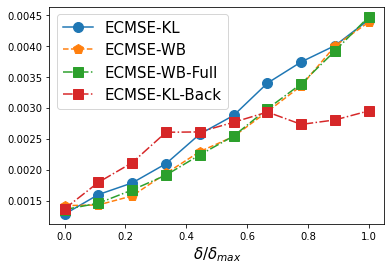

In [140]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed', label = "ECMSE-WB")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-WB-Full")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-KL-Back")


plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

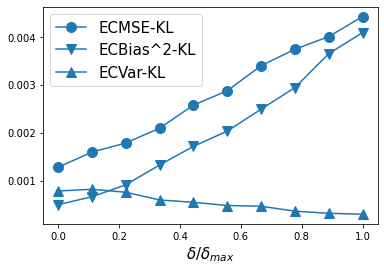

In [141]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color = '#1f77b4', label = "ECBias^2-KL")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0),marker="^",markersize=10,color='#1f77b4',label = "ECVar-KL")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

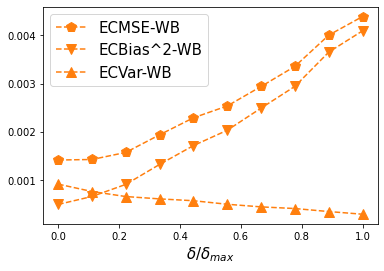

In [142]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed',color='#ff7f0e',label = "ECMSE-WB")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECBias^2-WB")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0),marker="^",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECVar-WB")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

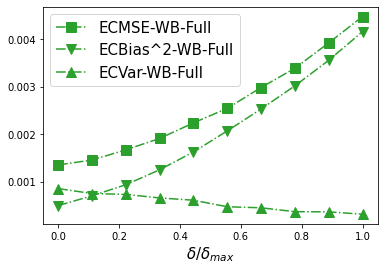

In [143]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#2ca02c',label = "ECMSE-WB-Full")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2),marker="v",markersize=10,color='#2ca02c',linestyle='-.',label = "ECBias^2-WB-Full")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0),marker="^",markersize=10,color='#2ca02c',linestyle='-.',label = "ECVar-WB-Full")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

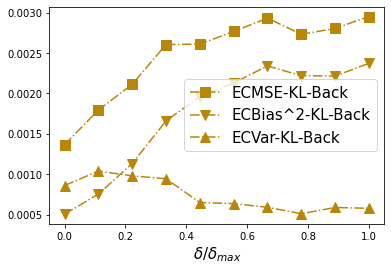

In [144]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#B8860B',label = "ECMSE-KL-Back")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2),marker="v",markersize=10,color='#B8860B',linestyle='-.',label = "ECBias^2-KL-Back")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0),marker="^",markersize=10,color='#B8860B',linestyle='-.',label = "ECVar-KL-Back")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()